In [37]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [38]:
pd.read_csv('action1.csv').tail()

lh  rh     ls     rs    w  ll   rl       0x       0y       1x  ...  \
3372  341   0   5909   9181  278   0  361  995.334  227.190  995.225  ...   
3373  335   0   6434   7678  278   0  365  998.094  227.202  995.334  ...   
3374  327   0  11304  10704  276   0  366  998.363  221.252  998.229  ...   
3375  321   0  11021  10376  275   0  368  998.135  230.063  995.333  ...   
3376  308   0  12518  10677  271   0  365  998.122  230.075  995.326  ...   

          20x      20y      21x      21y      22x      22y      23x      23y  \
3372  1112.97  1018.80  1048.35  980.668  818.735  998.230  815.820  980.655   
3373  1110.14  1018.79  1048.41  980.631  818.763  998.207  815.827  980.617   
3374  1110.14  1015.94  1051.20  980.672  821.695  998.316  815.880  983.552   
3375  1112.97  1018.77  1048.42  980.668  821.650  998.217  818.670  980.615   
3376  1110.12  1015.92  1048.33  980.554  821.685  998.216  818.685  980.615   

          24x      24y  
3372  895.260  968.814  
3373  895.242  968.873  
3374  895.242  965.875  
3375  895.286  965.889  
3376  895.222  965.881  

[5 rows x 57 columns]

In [39]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('action1.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)

# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,7:57].values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [40]:
# Define lookback period and split inputs/labels
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros((len(data)-lookback, 50))
print(inputs.shape)
print(labels.shape)
for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i][7:57]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1, 50)
print(inputs.shape)
print(labels.shape)

(3367, 10, 57)
(3367, 50)
(3367, 10, 57)
(3367, 50)


In [41]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]
print(test_y)
labs = torch.from_numpy(np.array(test_y))
label_sc.inverse_transform(labs)

[[0.99059549 0.53348462 0.80883156 ... 0.24408777 0.66784452 0.25181373]
 [0.88406124 0.39861568 0.79641005 ... 0.25296679 0.00911889 0.74464316]
 [0.88534026 0.39770793 0.7996178  ... 0.25151541 0.34184429 0.74987346]
 ...
 [0.88725877 0.39850221 0.80132405 ... 0.50038419 0.33796877 0.49805973]
 [0.87868186 0.59845683 0.60367185 ... 0.24963716 0.34298416 0.49924076]
 [0.87819283 0.59872915 0.6031941  ... 0.24963716 0.33568905 0.49856588]]


array([[1001.11 ,  227.2  ,  998.339, ...,  980.55 ,  898.136,  962.956],
       [ 998.278,  221.257,  998.157, ...,  980.654,  892.357,  968.798],
       [ 998.312,  221.217,  998.204, ...,  980.637,  895.276,  968.86 ],
       ...,
       [ 998.363,  221.252,  998.229, ...,  983.552,  895.242,  965.875],
       [ 998.135,  230.063,  995.333, ...,  980.615,  895.286,  965.889],
       [ 998.122,  230.075,  995.326, ...,  980.615,  895.222,  965.881]])

In [42]:
print(test_y)

[[0.99059549 0.53348462 0.80883156 ... 0.24408777 0.66784452 0.25181373]
 [0.88406124 0.39861568 0.79641005 ... 0.25296679 0.00911889 0.74464316]
 [0.88534026 0.39770793 0.7996178  ... 0.25151541 0.34184429 0.74987346]
 ...
 [0.88725877 0.39850221 0.80132405 ... 0.50038419 0.33796877 0.49805973]
 [0.87868186 0.59845683 0.60367185 ... 0.24963716 0.34298416 0.49924076]
 [0.87819283 0.59872915 0.6031941  ... 0.24963716 0.33568905 0.49856588]]


In [43]:
batch_size = 10

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
input_dim = next(iter(train_loader))[0].shape
print(input_dim)

torch.Size([10, 10, 57])


In [44]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [45]:
print(device)

cpu


In [46]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [47]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 50
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [48]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [49]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/303....... Average Loss for Epoch: 0.3534032106399536
Epoch 1......Step: 2/303....... Average Loss for Epoch: 0.30774612724781036
Epoch 1......Step: 3/303....... Average Loss for Epoch: 0.2745816757281621
Epoch 1......Step: 4/303....... Average Loss for Epoch: 0.23886144533753395
Epoch 1......Step: 5/303....... Average Loss for Epoch: 0.20645857602357864
Epoch 1......Step: 6/303....... Average Loss for Epoch: 0.1827137420574824
Epoch 1......Step: 7/303....... Average Loss for Epoch: 0.1663269687976156
Epoch 1......Step: 8/303....... Average Loss for Epoch: 0.1536504728719592
Epoch 1......Step: 9/303....... Average Loss for Epoch: 0.14332611734668413
Epoch 1......Step: 10/303....... Average Loss for Epoch: 0.13349276930093765
Epoch 1......Step: 11/303....... Average Loss for Epoch: 0.12555828351866116
Epoch 1......Step: 12/303....... Average Loss for Epoch: 0.11841448706885178
Epoch 1......Step: 13/303....... Average Loss for Epoch: 0.

Epoch 1......Step: 112/303....... Average Loss for Epoch: 0.039050170952188115
Epoch 1......Step: 113/303....... Average Loss for Epoch: 0.0389016151296354
Epoch 1......Step: 114/303....... Average Loss for Epoch: 0.03873941225506235
Epoch 1......Step: 115/303....... Average Loss for Epoch: 0.03856219143971153
Epoch 1......Step: 116/303....... Average Loss for Epoch: 0.03840979211160849
Epoch 1......Step: 117/303....... Average Loss for Epoch: 0.03829018811448517
Epoch 1......Step: 118/303....... Average Loss for Epoch: 0.03816651860725576
Epoch 1......Step: 119/303....... Average Loss for Epoch: 0.03802260131958653
Epoch 1......Step: 120/303....... Average Loss for Epoch: 0.03786584959986309
Epoch 1......Step: 121/303....... Average Loss for Epoch: 0.037755150347948074
Epoch 1......Step: 122/303....... Average Loss for Epoch: 0.03764940077652697
Epoch 1......Step: 123/303....... Average Loss for Epoch: 0.03751652774105712
Epoch 1......Step: 124/303....... Average Loss for Epoch: 0.037

Epoch 1......Step: 225/303....... Average Loss for Epoch: 0.030801450262467066
Epoch 1......Step: 226/303....... Average Loss for Epoch: 0.030803429803489584
Epoch 1......Step: 227/303....... Average Loss for Epoch: 0.030735786520108777
Epoch 1......Step: 228/303....... Average Loss for Epoch: 0.030697339059164126
Epoch 1......Step: 229/303....... Average Loss for Epoch: 0.03063427233116856
Epoch 1......Step: 230/303....... Average Loss for Epoch: 0.03056988066629223
Epoch 1......Step: 231/303....... Average Loss for Epoch: 0.03050552477084455
Epoch 1......Step: 232/303....... Average Loss for Epoch: 0.03048180185001472
Epoch 1......Step: 233/303....... Average Loss for Epoch: 0.03043013475355672
Epoch 1......Step: 234/303....... Average Loss for Epoch: 0.030380762580177214
Epoch 1......Step: 235/303....... Average Loss for Epoch: 0.030336037087947763
Epoch 1......Step: 236/303....... Average Loss for Epoch: 0.030290538831850736
Epoch 1......Step: 237/303....... Average Loss for Epoch:

Epoch 2......Step: 25/303....... Average Loss for Epoch: 0.022202466689050196
Epoch 2......Step: 26/303....... Average Loss for Epoch: 0.022074496552634697
Epoch 2......Step: 27/303....... Average Loss for Epoch: 0.022139214496645663
Epoch 2......Step: 28/303....... Average Loss for Epoch: 0.022226330458319614
Epoch 2......Step: 29/303....... Average Loss for Epoch: 0.022137217191529685
Epoch 2......Step: 30/303....... Average Loss for Epoch: 0.021976592484861612
Epoch 2......Step: 31/303....... Average Loss for Epoch: 0.0219046124106934
Epoch 2......Step: 32/303....... Average Loss for Epoch: 0.02196352757164277
Epoch 2......Step: 33/303....... Average Loss for Epoch: 0.02198960454287854
Epoch 2......Step: 34/303....... Average Loss for Epoch: 0.021974565159967718
Epoch 2......Step: 35/303....... Average Loss for Epoch: 0.021804447658360003
Epoch 2......Step: 36/303....... Average Loss for Epoch: 0.02160792564973235
Epoch 2......Step: 37/303....... Average Loss for Epoch: 0.0215217212

Epoch 2......Step: 139/303....... Average Loss for Epoch: 0.020637032415101425
Epoch 2......Step: 140/303....... Average Loss for Epoch: 0.020651392179674335
Epoch 2......Step: 141/303....... Average Loss for Epoch: 0.020645093417178233
Epoch 2......Step: 142/303....... Average Loss for Epoch: 0.02062554603022799
Epoch 2......Step: 143/303....... Average Loss for Epoch: 0.02063099981995521
Epoch 2......Step: 144/303....... Average Loss for Epoch: 0.020662970420542277
Epoch 2......Step: 145/303....... Average Loss for Epoch: 0.020616669850102787
Epoch 2......Step: 146/303....... Average Loss for Epoch: 0.020653377644309443
Epoch 2......Step: 147/303....... Average Loss for Epoch: 0.0207047217912009
Epoch 2......Step: 148/303....... Average Loss for Epoch: 0.020723116659634822
Epoch 2......Step: 149/303....... Average Loss for Epoch: 0.020718298014878428
Epoch 2......Step: 150/303....... Average Loss for Epoch: 0.02070958378414313
Epoch 2......Step: 151/303....... Average Loss for Epoch:

Epoch 2......Step: 251/303....... Average Loss for Epoch: 0.020206914324150144
Epoch 2......Step: 252/303....... Average Loss for Epoch: 0.020219577217681542
Epoch 2......Step: 253/303....... Average Loss for Epoch: 0.020204873210768925
Epoch 2......Step: 254/303....... Average Loss for Epoch: 0.020235210429789045
Epoch 2......Step: 255/303....... Average Loss for Epoch: 0.02022193611836901
Epoch 2......Step: 256/303....... Average Loss for Epoch: 0.020202695919579128
Epoch 2......Step: 257/303....... Average Loss for Epoch: 0.020200378638384177
Epoch 2......Step: 258/303....... Average Loss for Epoch: 0.020182016309235218
Epoch 2......Step: 259/303....... Average Loss for Epoch: 0.020166865535598235
Epoch 2......Step: 260/303....... Average Loss for Epoch: 0.020158404301708708
Epoch 2......Step: 261/303....... Average Loss for Epoch: 0.0201950089620619
Epoch 2......Step: 262/303....... Average Loss for Epoch: 0.020191179983005042
Epoch 2......Step: 263/303....... Average Loss for Epoc

Epoch 3......Step: 52/303....... Average Loss for Epoch: 0.016973023696874198
Epoch 3......Step: 53/303....... Average Loss for Epoch: 0.01720711701321152
Epoch 3......Step: 54/303....... Average Loss for Epoch: 0.017216478853865905
Epoch 3......Step: 55/303....... Average Loss for Epoch: 0.01719866432249546
Epoch 3......Step: 56/303....... Average Loss for Epoch: 0.017182570416480303
Epoch 3......Step: 57/303....... Average Loss for Epoch: 0.017084625925411257
Epoch 3......Step: 58/303....... Average Loss for Epoch: 0.017095611173788022
Epoch 3......Step: 59/303....... Average Loss for Epoch: 0.017204178781327555
Epoch 3......Step: 60/303....... Average Loss for Epoch: 0.017270006363590558
Epoch 3......Step: 61/303....... Average Loss for Epoch: 0.01730838130976333
Epoch 3......Step: 62/303....... Average Loss for Epoch: 0.01749477694712339
Epoch 3......Step: 63/303....... Average Loss for Epoch: 0.017474954356513327
Epoch 3......Step: 64/303....... Average Loss for Epoch: 0.017487436

Epoch 3......Step: 162/303....... Average Loss for Epoch: 0.018432212619823807
Epoch 3......Step: 163/303....... Average Loss for Epoch: 0.01843162994557546
Epoch 3......Step: 164/303....... Average Loss for Epoch: 0.018445951665365477
Epoch 3......Step: 165/303....... Average Loss for Epoch: 0.018418431581195556
Epoch 3......Step: 166/303....... Average Loss for Epoch: 0.018464681249201656
Epoch 3......Step: 167/303....... Average Loss for Epoch: 0.01846051682902132
Epoch 3......Step: 168/303....... Average Loss for Epoch: 0.018437826113464933
Epoch 3......Step: 169/303....... Average Loss for Epoch: 0.018415359052768827
Epoch 3......Step: 170/303....... Average Loss for Epoch: 0.01841276484158109
Epoch 3......Step: 171/303....... Average Loss for Epoch: 0.01840242521281828
Epoch 3......Step: 172/303....... Average Loss for Epoch: 0.01839031688435826
Epoch 3......Step: 173/303....... Average Loss for Epoch: 0.018370866920863618
Epoch 3......Step: 174/303....... Average Loss for Epoch:

Epoch 3......Step: 266/303....... Average Loss for Epoch: 0.01838863830089121
Epoch 3......Step: 267/303....... Average Loss for Epoch: 0.018388154738572207
Epoch 3......Step: 268/303....... Average Loss for Epoch: 0.018369830418517117
Epoch 3......Step: 269/303....... Average Loss for Epoch: 0.018345075091658693
Epoch 3......Step: 270/303....... Average Loss for Epoch: 0.01833170323667151
Epoch 3......Step: 271/303....... Average Loss for Epoch: 0.01833203202972663
Epoch 3......Step: 272/303....... Average Loss for Epoch: 0.018310215676833382
Epoch 3......Step: 273/303....... Average Loss for Epoch: 0.018313228568887754
Epoch 3......Step: 274/303....... Average Loss for Epoch: 0.018364087090467232
Epoch 3......Step: 275/303....... Average Loss for Epoch: 0.018377726867117666
Epoch 3......Step: 276/303....... Average Loss for Epoch: 0.018367159949696583
Epoch 3......Step: 277/303....... Average Loss for Epoch: 0.01836725908738396
Epoch 3......Step: 278/303....... Average Loss for Epoch

Epoch 4......Step: 75/303....... Average Loss for Epoch: 0.017772877104580403
Epoch 4......Step: 76/303....... Average Loss for Epoch: 0.017768453206180743
Epoch 4......Step: 77/303....... Average Loss for Epoch: 0.017702176537993667
Epoch 4......Step: 78/303....... Average Loss for Epoch: 0.01763040214203871
Epoch 4......Step: 79/303....... Average Loss for Epoch: 0.01757930911181471
Epoch 4......Step: 80/303....... Average Loss for Epoch: 0.017553806130308658
Epoch 4......Step: 81/303....... Average Loss for Epoch: 0.017706659162578024
Epoch 4......Step: 82/303....... Average Loss for Epoch: 0.01766220847053862
Epoch 4......Step: 83/303....... Average Loss for Epoch: 0.017669190652668476
Epoch 4......Step: 84/303....... Average Loss for Epoch: 0.017613733442322838
Epoch 4......Step: 85/303....... Average Loss for Epoch: 0.0176326033714063
Epoch 4......Step: 86/303....... Average Loss for Epoch: 0.01766582923876338
Epoch 4......Step: 87/303....... Average Loss for Epoch: 0.01762382405

Epoch 4......Step: 187/303....... Average Loss for Epoch: 0.01749266649192986
Epoch 4......Step: 188/303....... Average Loss for Epoch: 0.017520116176456213
Epoch 4......Step: 189/303....... Average Loss for Epoch: 0.017560329229112655
Epoch 4......Step: 190/303....... Average Loss for Epoch: 0.017541089560836554
Epoch 4......Step: 191/303....... Average Loss for Epoch: 0.017554617525902406
Epoch 4......Step: 192/303....... Average Loss for Epoch: 0.017551362529047765
Epoch 4......Step: 193/303....... Average Loss for Epoch: 0.01754361364527224
Epoch 4......Step: 194/303....... Average Loss for Epoch: 0.01751886250585625
Epoch 4......Step: 195/303....... Average Loss for Epoch: 0.017515400185798988
Epoch 4......Step: 196/303....... Average Loss for Epoch: 0.017551412520816132
Epoch 4......Step: 197/303....... Average Loss for Epoch: 0.01755831534336061
Epoch 4......Step: 198/303....... Average Loss for Epoch: 0.01752872567510966
Epoch 4......Step: 199/303....... Average Loss for Epoch:

Epoch 4......Step: 299/303....... Average Loss for Epoch: 0.017702844495383594
Epoch 4......Step: 300/303....... Average Loss for Epoch: 0.017699632169678806
Epoch 4......Step: 301/303....... Average Loss for Epoch: 0.017686165417498134
Epoch 4......Step: 302/303....... Average Loss for Epoch: 0.017698254393080606
Epoch 4......Step: 303/303....... Average Loss for Epoch: 0.01769412790883099
Epoch 4/5 Done, Total Loss: 0.01769412790883099
Time Elapsed for Epoch: 5.647422100000313 seconds
Epoch 5......Step: 1/303....... Average Loss for Epoch: 0.017694024369120598
Epoch 5......Step: 2/303....... Average Loss for Epoch: 0.017846280708909035
Epoch 5......Step: 3/303....... Average Loss for Epoch: 0.0162821002304554
Epoch 5......Step: 4/303....... Average Loss for Epoch: 0.0173398875631392
Epoch 5......Step: 5/303....... Average Loss for Epoch: 0.016743332706391813
Epoch 5......Step: 6/303....... Average Loss for Epoch: 0.0156683133294185
Epoch 5......Step: 7/303....... Average Loss for Epo

Epoch 5......Step: 107/303....... Average Loss for Epoch: 0.01767532241086815
Epoch 5......Step: 108/303....... Average Loss for Epoch: 0.017692767247488653
Epoch 5......Step: 109/303....... Average Loss for Epoch: 0.017693564714436685
Epoch 5......Step: 110/303....... Average Loss for Epoch: 0.017675329922613774
Epoch 5......Step: 111/303....... Average Loss for Epoch: 0.017695400536664435
Epoch 5......Step: 112/303....... Average Loss for Epoch: 0.017658350232522935
Epoch 5......Step: 113/303....... Average Loss for Epoch: 0.017621893353298702
Epoch 5......Step: 114/303....... Average Loss for Epoch: 0.017623564849297207
Epoch 5......Step: 115/303....... Average Loss for Epoch: 0.01757598568725845
Epoch 5......Step: 116/303....... Average Loss for Epoch: 0.01759972536518913
Epoch 5......Step: 117/303....... Average Loss for Epoch: 0.0176262310347878
Epoch 5......Step: 118/303....... Average Loss for Epoch: 0.017615120344937354
Epoch 5......Step: 119/303....... Average Loss for Epoch:

Epoch 5......Step: 213/303....... Average Loss for Epoch: 0.017051805427271714
Epoch 5......Step: 214/303....... Average Loss for Epoch: 0.01704916040735128
Epoch 5......Step: 215/303....... Average Loss for Epoch: 0.017062140988229318
Epoch 5......Step: 216/303....... Average Loss for Epoch: 0.01707055839209783
Epoch 5......Step: 217/303....... Average Loss for Epoch: 0.017048943487386548
Epoch 5......Step: 218/303....... Average Loss for Epoch: 0.01703862108529434
Epoch 5......Step: 219/303....... Average Loss for Epoch: 0.017048999003759804
Epoch 5......Step: 220/303....... Average Loss for Epoch: 0.01707332752306353
Epoch 5......Step: 221/303....... Average Loss for Epoch: 0.017112648055564224
Epoch 5......Step: 222/303....... Average Loss for Epoch: 0.01712018686036269
Epoch 5......Step: 223/303....... Average Loss for Epoch: 0.017109304090185014
Epoch 5......Step: 224/303....... Average Loss for Epoch: 0.017096239038177634
Epoch 5......Step: 225/303....... Average Loss for Epoch:

In [50]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.06628069999987929
sMAPE: 0.20795431325823754%


In [51]:
print(gru_outputs[0].reshape(-1, 50))

[[998.2459  224.69212 998.5482  ... 982.09814 893.6743  967.83923]
 [998.0306  224.97612 998.588   ... 981.7006  893.94696 967.6186 ]
 [998.3555  223.9675  997.5653  ... 981.80646 893.9774  967.5926 ]
 ...
 [997.15515 229.67789 996.1493  ... 980.33563 894.65796 967.5616 ]
 [996.2762  229.53543 996.4688  ... 980.2879  894.54785 967.00104]
 [996.9954  231.32501 995.9     ... 980.3415  895.0398  966.6826 ]]


In [52]:
print(targets[0].reshape(-1, 50))
print(targets[0].reshape(-1, 50)[-1].reshape(-1,2).tolist())

[[1001.11   227.2    998.339 ...  980.55   898.136  962.956]
 [ 998.278  221.257  998.157 ...  980.654  892.357  968.798]
 [ 998.312  221.217  998.204 ...  980.637  895.276  968.86 ]
 ...
 [ 998.363  221.252  998.229 ...  983.552  895.242  965.875]
 [ 998.135  230.063  995.333 ...  980.615  895.286  965.889]
 [ 998.122  230.075  995.326 ...  980.615  895.222  965.881]]
[[998.122, 230.07499999999996], [995.3260000000001, 341.85], [910.047, 341.8], [880.431, 412.657], [833.513, 480.244], [1071.86, 341.944], [1098.43, 412.716], [1124.82, 486.161], [977.7289999999999, 574.47], [930.581, 574.419], [909.998, 765.7139999999999], [883.4029999999999, 951.168], [1024.79, 574.51], [1048.38, 774.6120000000001], [1068.72, 971.7219999999999], [977.66, 218.315], [1015.8700000000001, 221.153], [954.02, 230.10899999999998], [1036.49, 241.75599999999997], [1095.31, 1024.82], [1110.12, 1015.92], [1048.33, 980.554], [821.685, 998.2160000000001], [818.685, 980.615], [895.2219999999999, 965.8810000000001]]


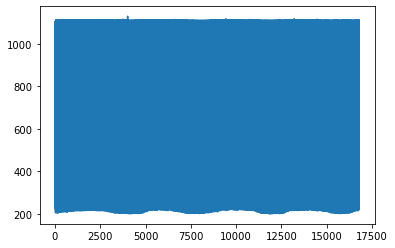

In [53]:
plt.plot(gru_outputs[0])
plt.show()

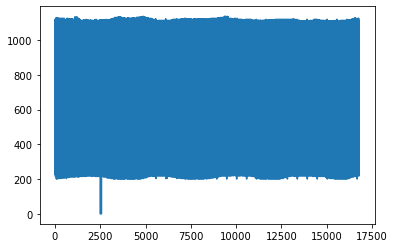

In [54]:
plt.plot(targets[0])
plt.show()

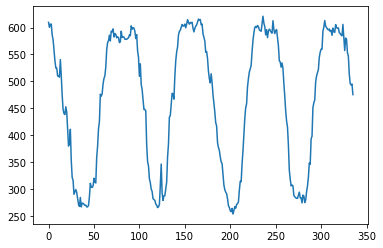

In [55]:
tp = []
for row in gru_outputs[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

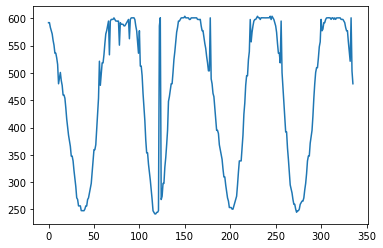

In [56]:
tp = []
for row in targets[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# h36m骨架连接顺序，每个骨架三个维度，分别为：起始关节，终止关节，左右关节标识(0 left 1 right)
connectivity_dict = [[0, 1, 0], [0, 15, 0], [0, 16, 1], [17, 15, 0], [18, 16, 1], [1, 2, 0], [2, 3, 0],
                              [3, 4, 0], [1, 5, 1], [5, 6, 1],
                              [6, 7, 1], [1, 8, 0], [8, 9, 0], [9, 10, 0], [10, 11, 0], [11, 24, 0],
                              [11, 22, 0], [22, 23, 0], [8, 12, 1], [12, 13, 1], [13, 14, 1], [14, 21, 1],
                              [14, 19, 1], [19, 20, 1]]


def draw2Dpose(pose_2d, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False):  # blue, orange
    for i in connectivity_dict:
        x, y = [np.array([pose_2d[i[0], j], pose_2d[i[1], j]]) for j in range(2)]
        ax.plot(x, y, lw=2, c=lcolor if i[2] else rcolor)
        

In [58]:
ps = []
for p in gru_outputs[0].reshape(-1, 50):
    ps.append(np.array(p.reshape(-1,2).tolist()))

print(ps)

[array([[ 998.24591064,  224.69212341],
       [ 998.54821777,  346.67218018],
       [ 910.58251953,  347.01547241],
       [ 882.73431396,  464.34423828],
       [ 816.90661621,  609.61968994],
       [1076.79431152,  350.51187134],
       [1103.57006836,  471.45040894],
       [1094.46166992,  584.36676025],
       [ 985.37597656,  590.77038574],
       [ 938.85534668,  586.59570312],
       [ 910.5647583 ,  766.97033691],
       [ 883.35174561,  951.32818604],
       [1034.3951416 ,  589.99462891],
       [1049.22216797,  779.61993408],
       [1068.6184082 ,  971.52642822],
       [ 978.18249512,  204.89309692],
       [1021.86016846,  206.88449097],
       [ 955.07983398,  225.15316772],
       [1043.7512207 ,  233.96073914],
       [1094.80639648, 1025.01159668],
       [1111.81054688, 1016.63000488],
       [1048.41271973,  980.74383545],
       [ 824.1595459 ,  998.00683594],
       [ 818.26434326,  982.09814453],
       [ 893.67431641,  967.8392334 ]]), array([[ 998.03057861,

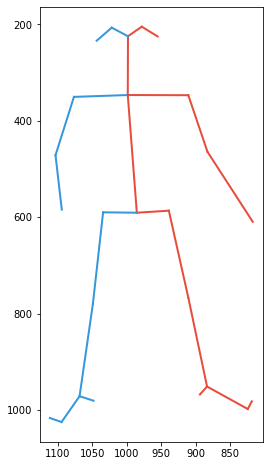

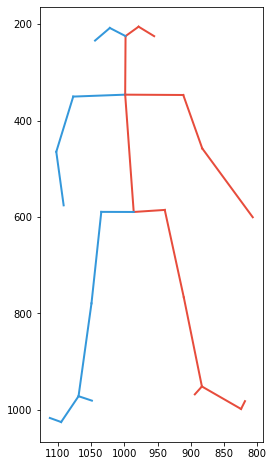

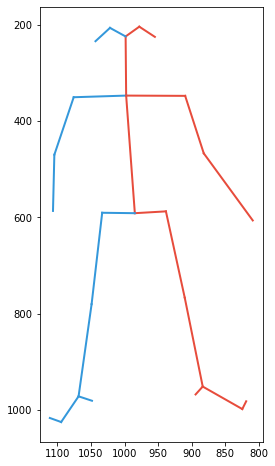

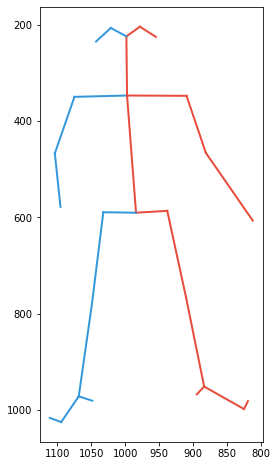

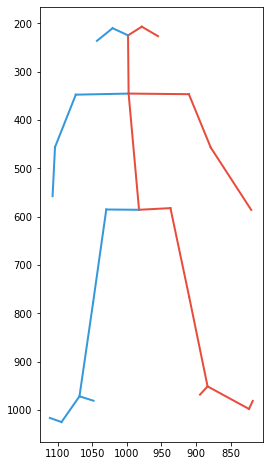

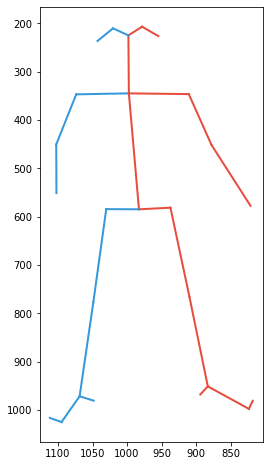

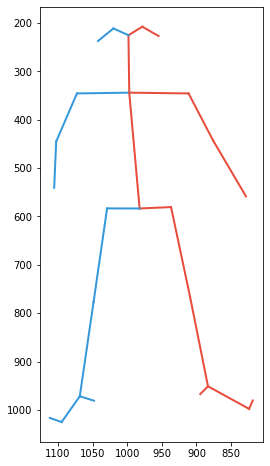

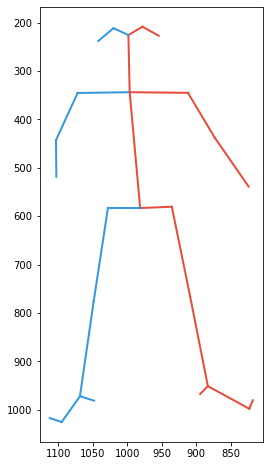

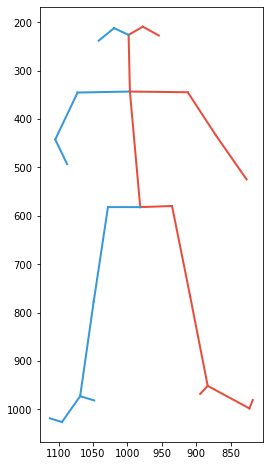

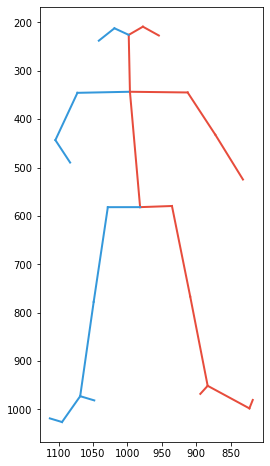

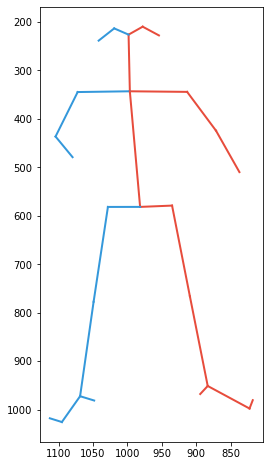

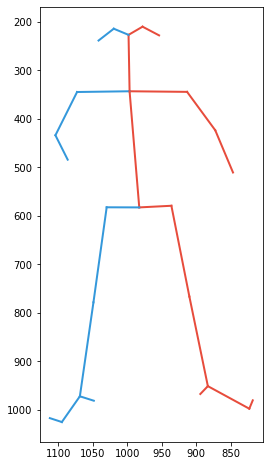

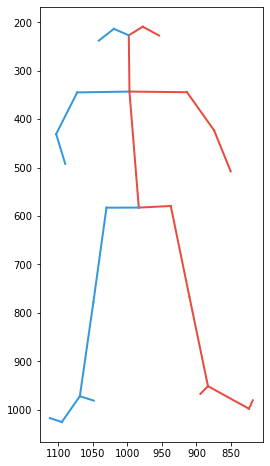

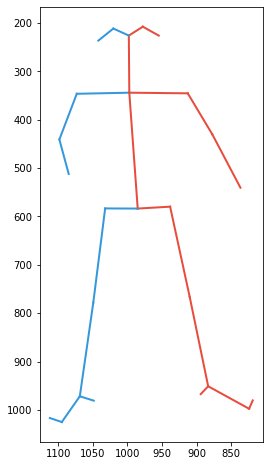

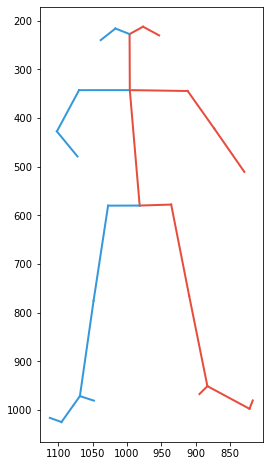

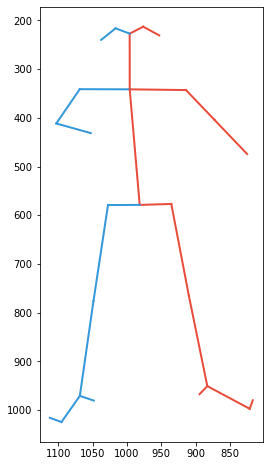

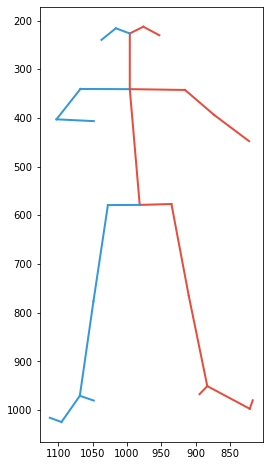

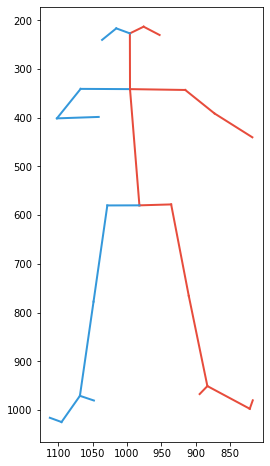

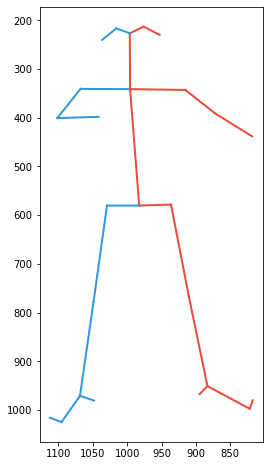

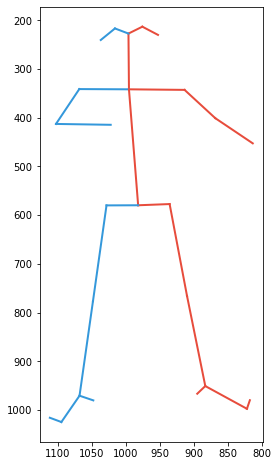

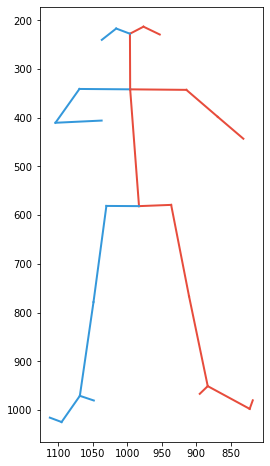

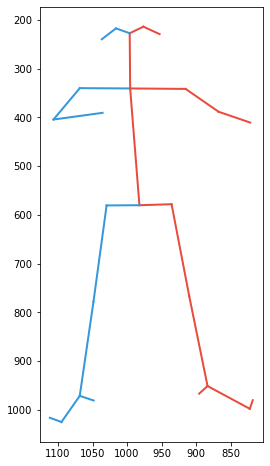

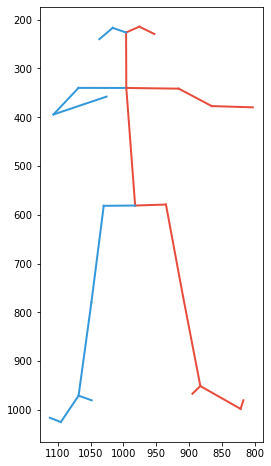

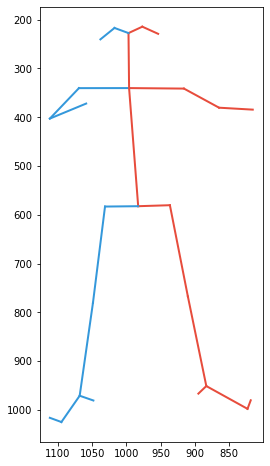

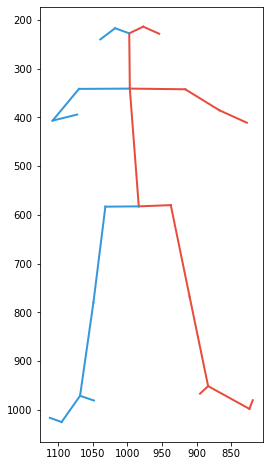

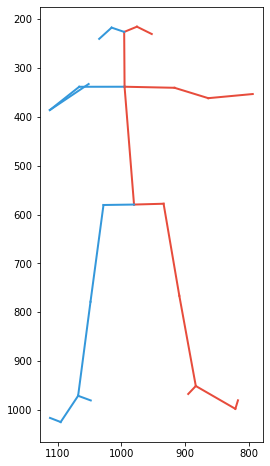

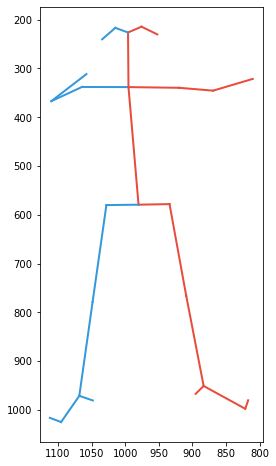

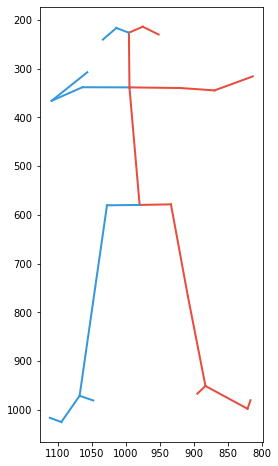

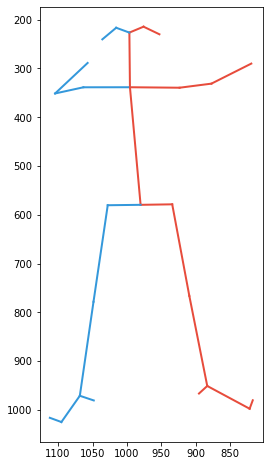

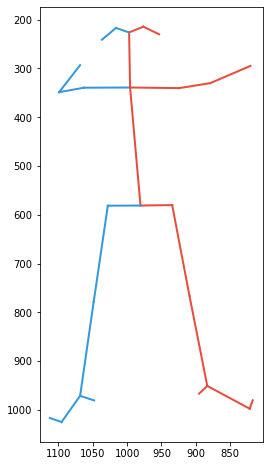

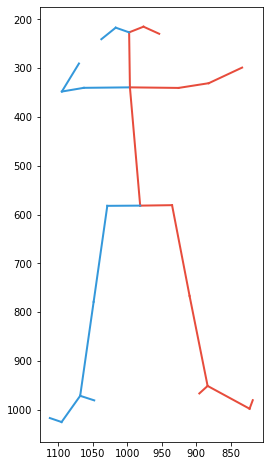

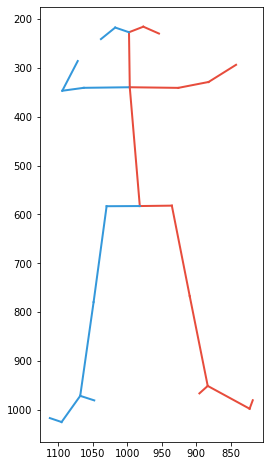

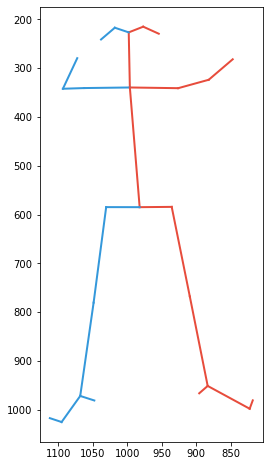

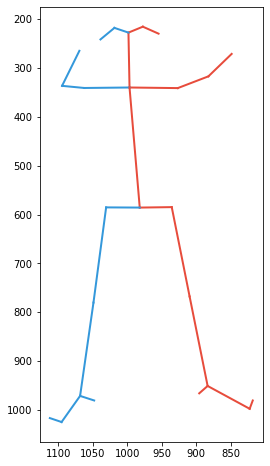

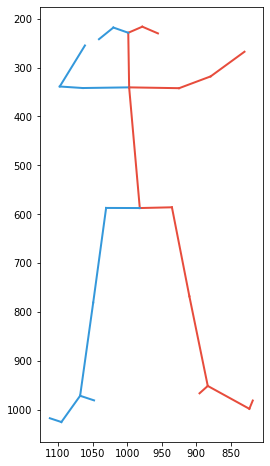

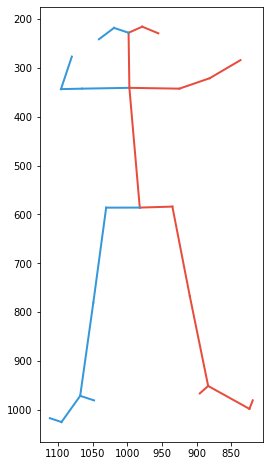

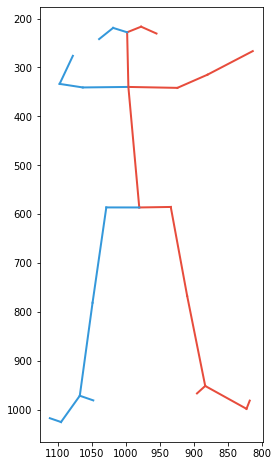

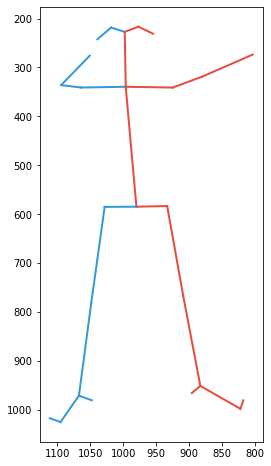

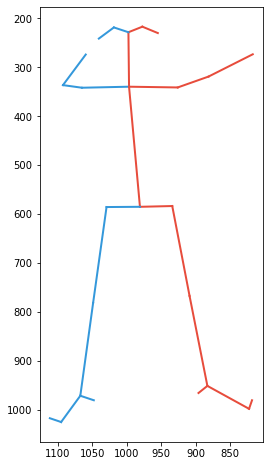

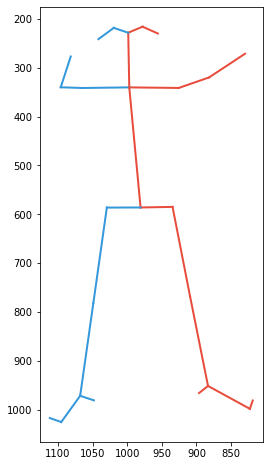

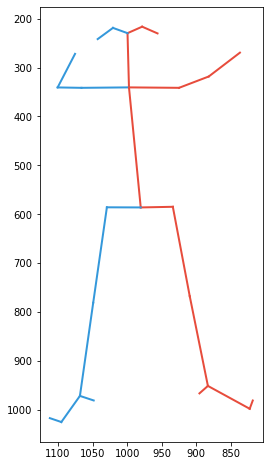

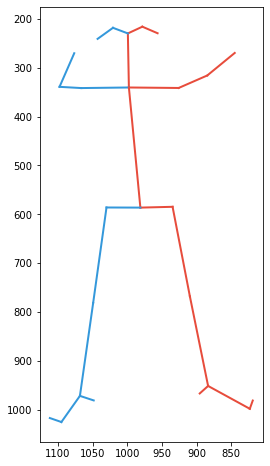

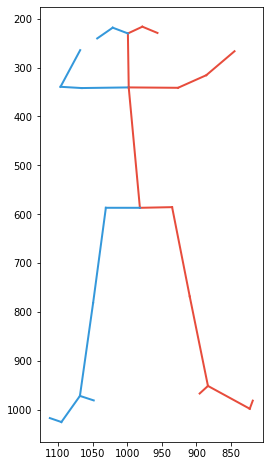

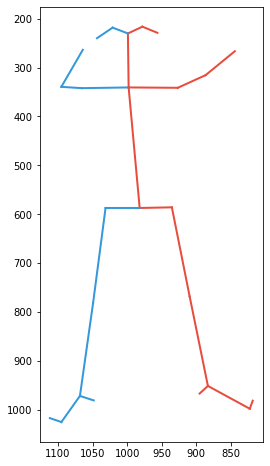

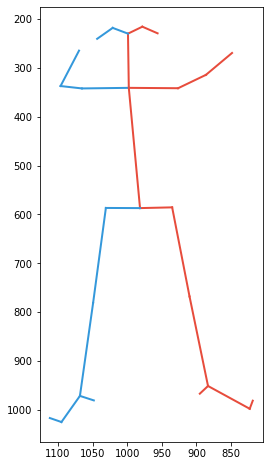

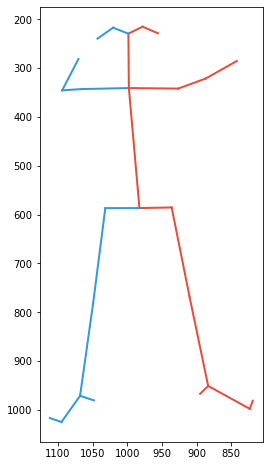

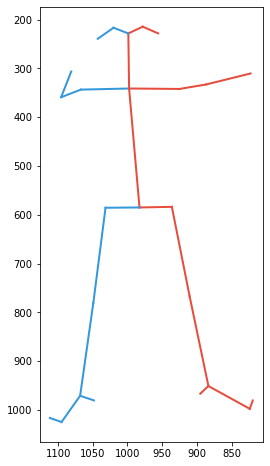

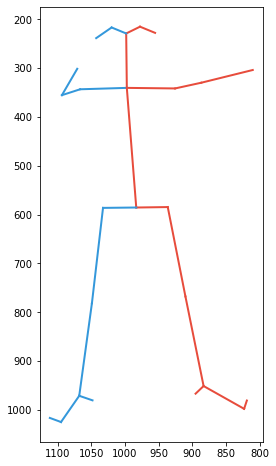

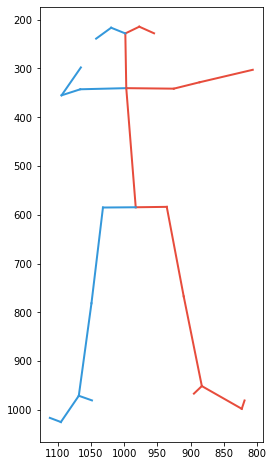

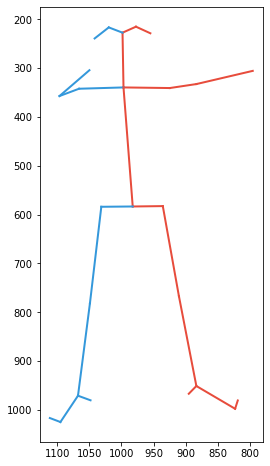

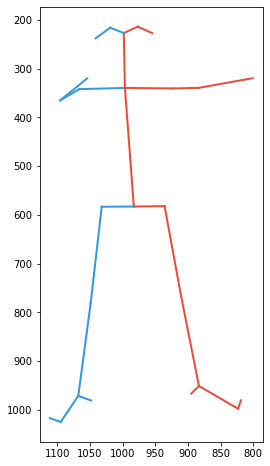

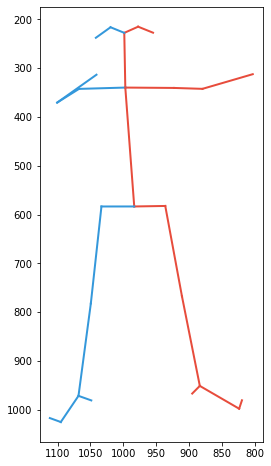

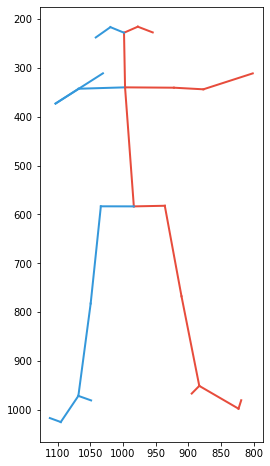

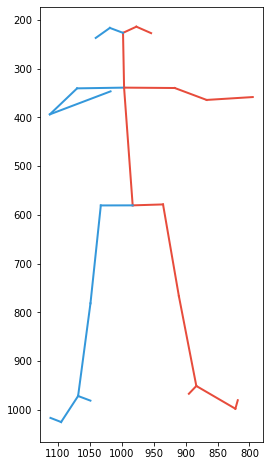

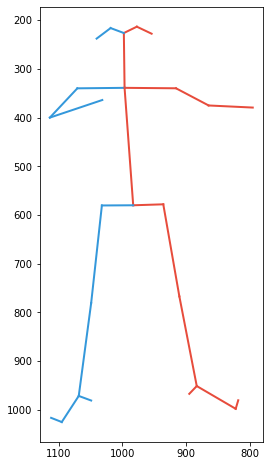

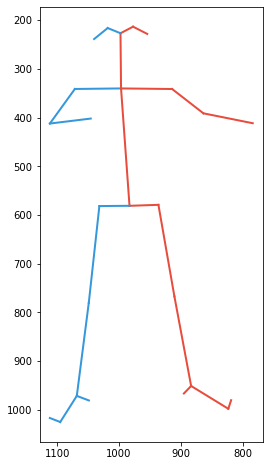

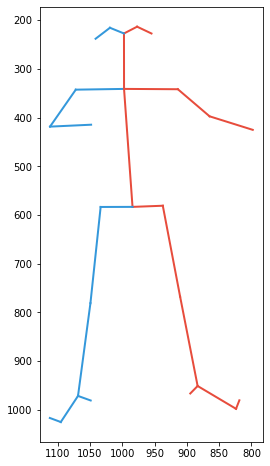

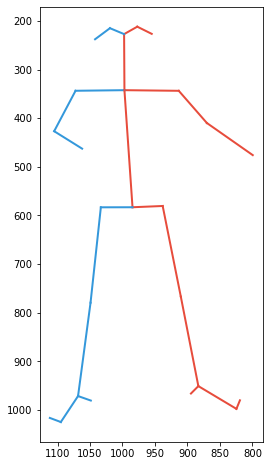

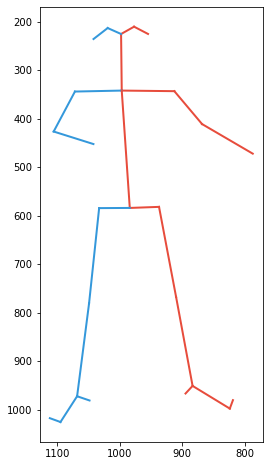

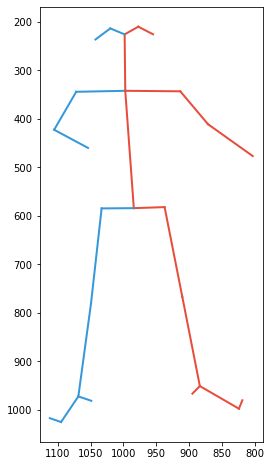

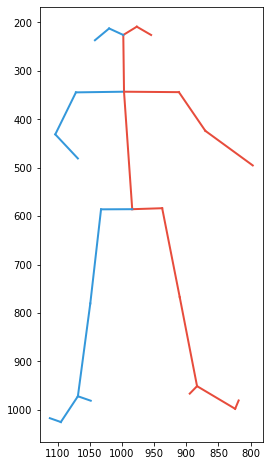

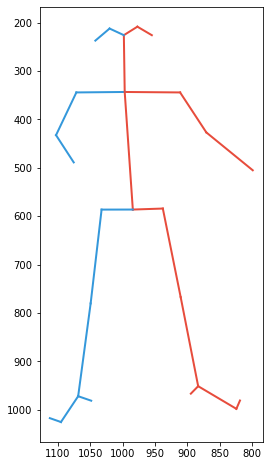

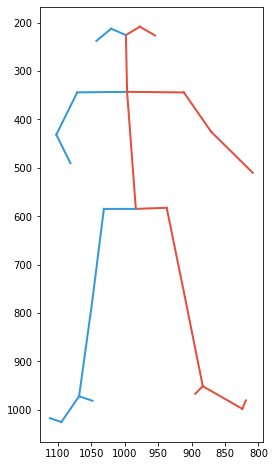

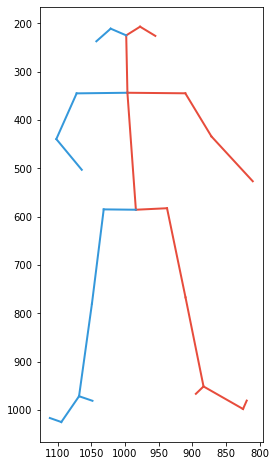

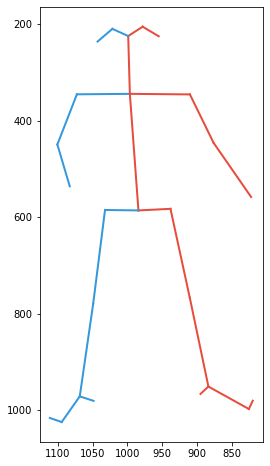

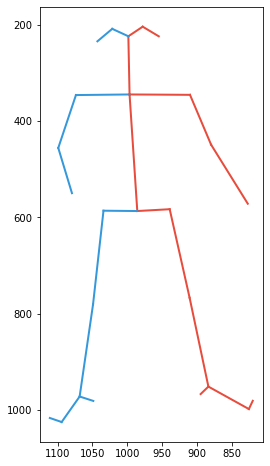

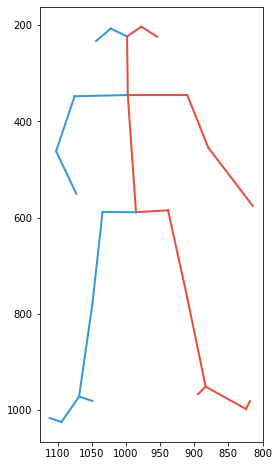

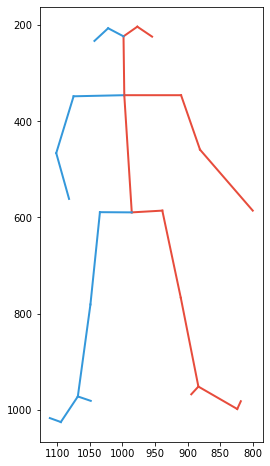

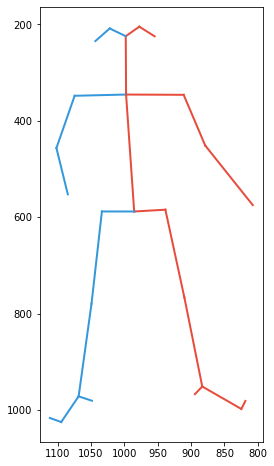

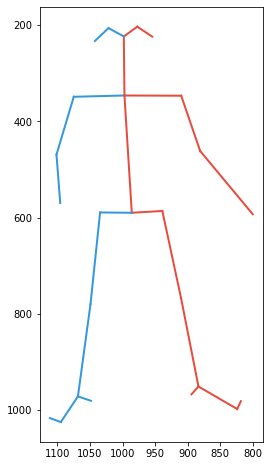

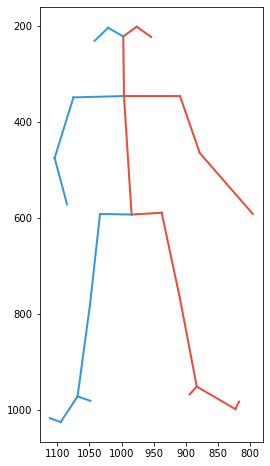

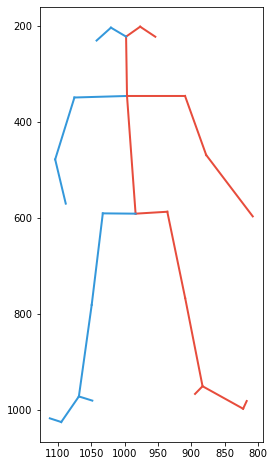

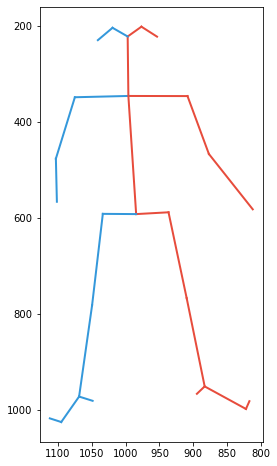

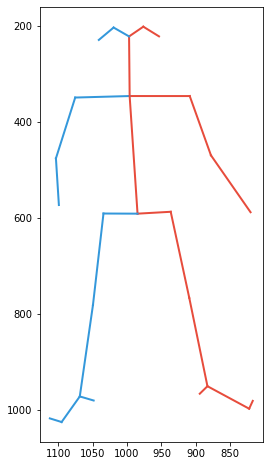

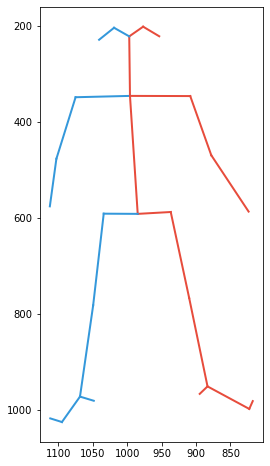

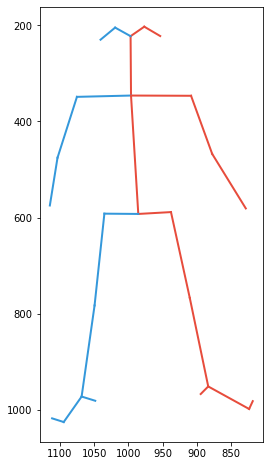

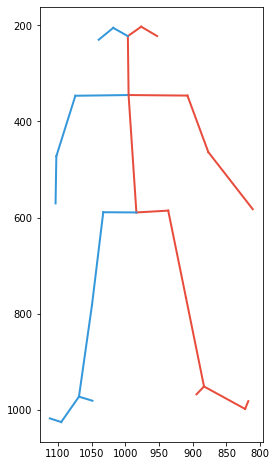

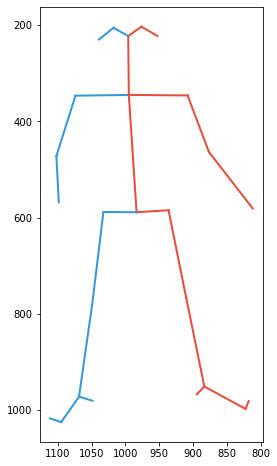

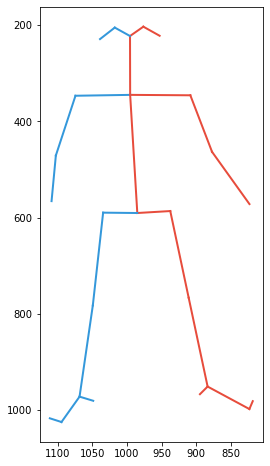

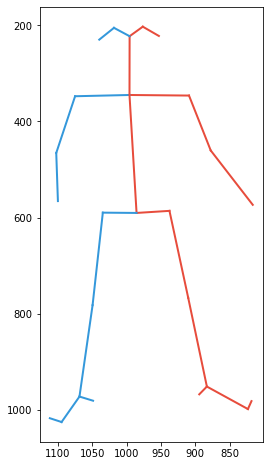

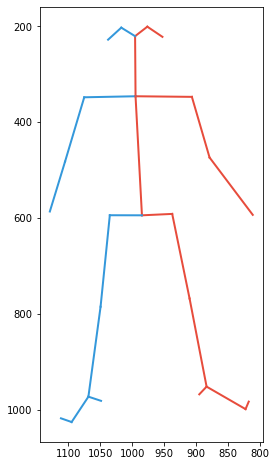

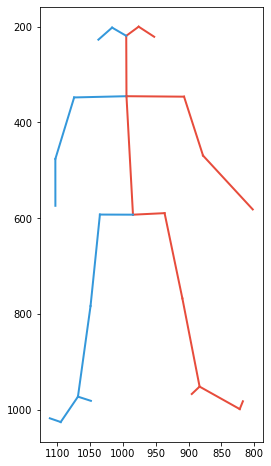

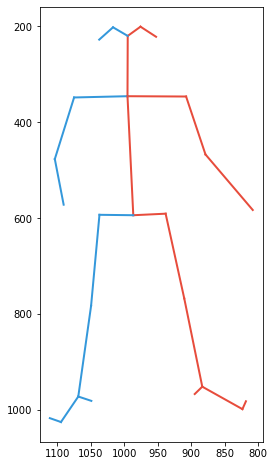

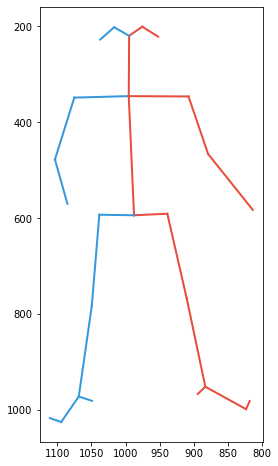

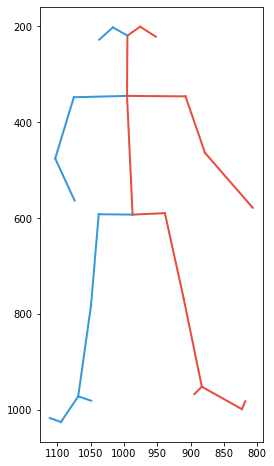

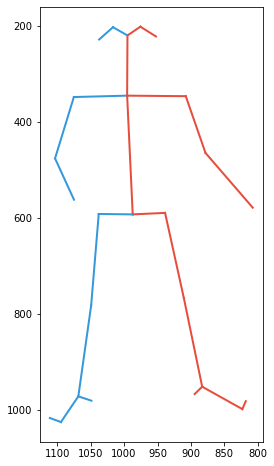

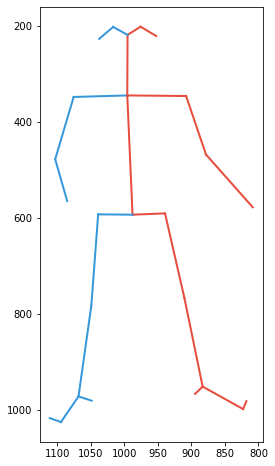

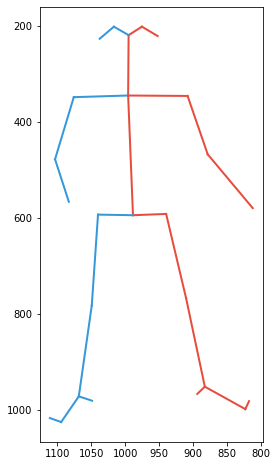

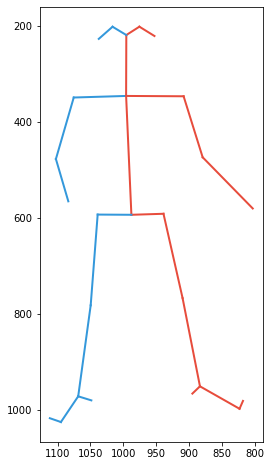

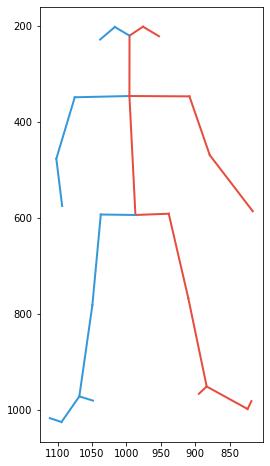

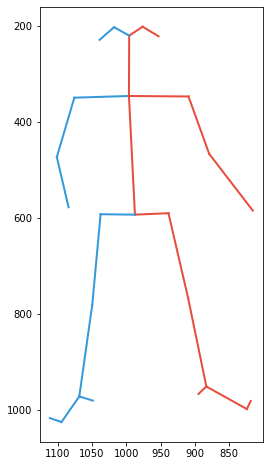

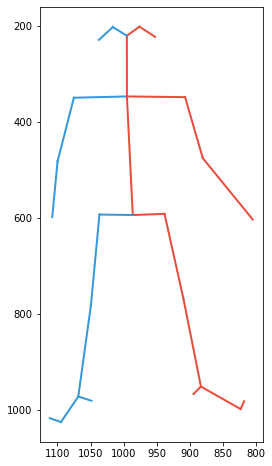

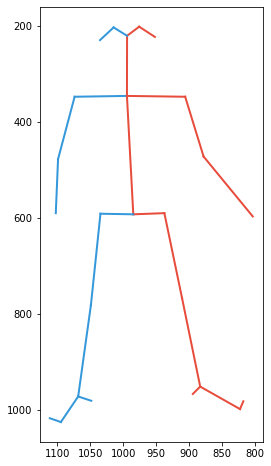

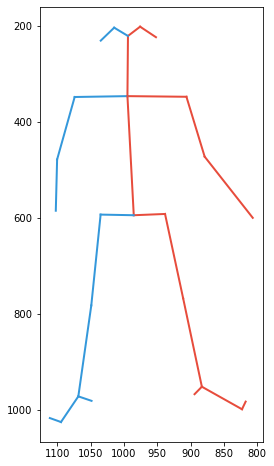

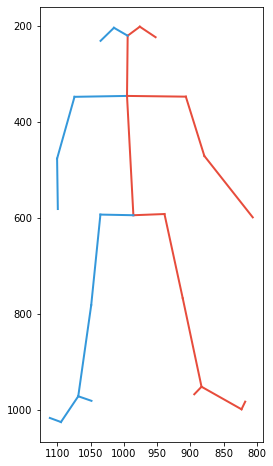

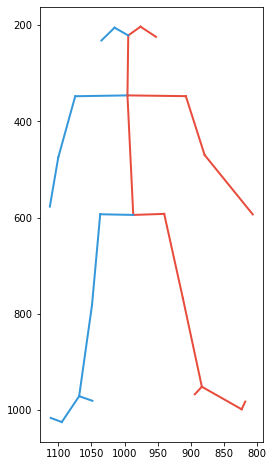

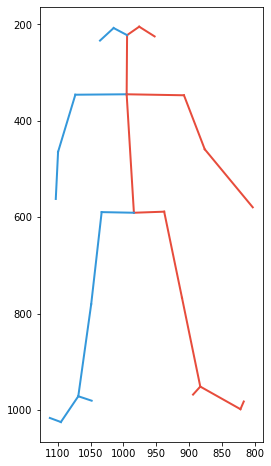

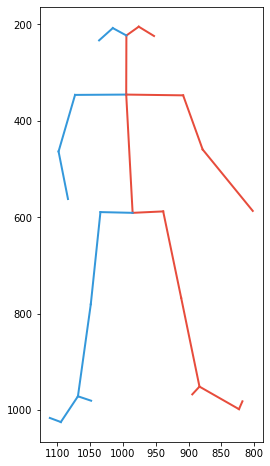

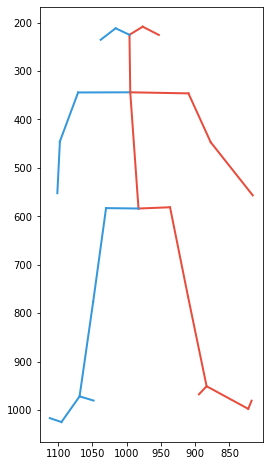

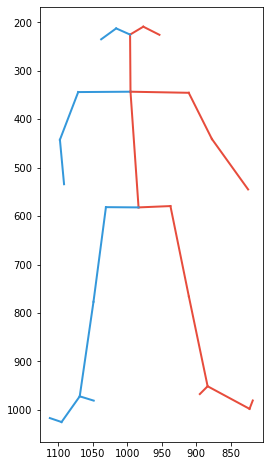

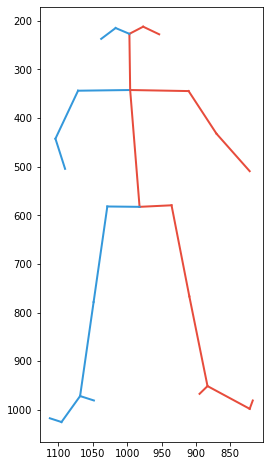

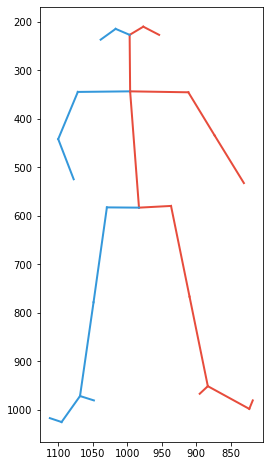

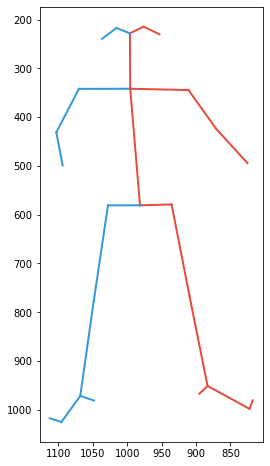

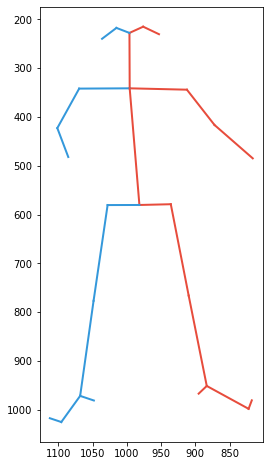

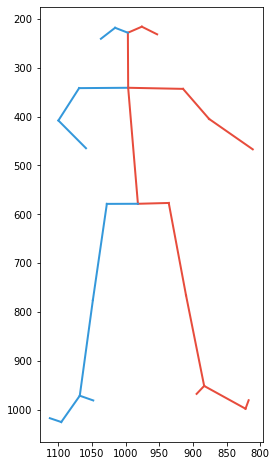

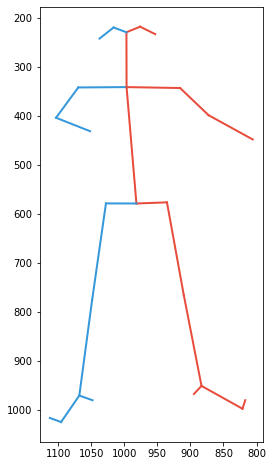

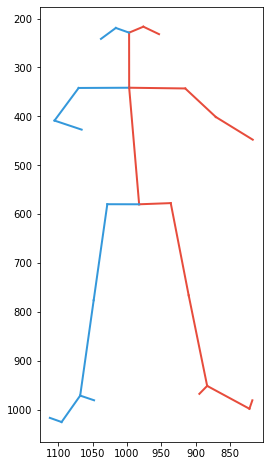

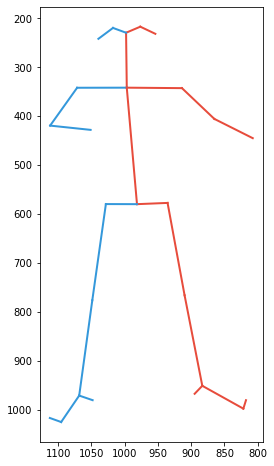

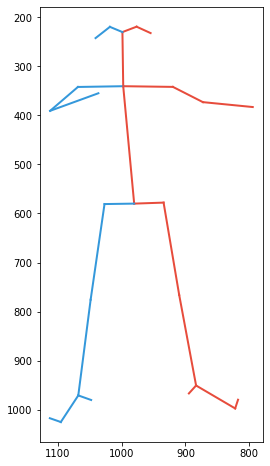

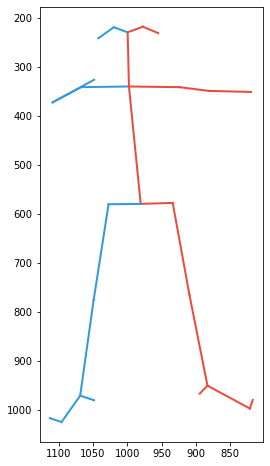

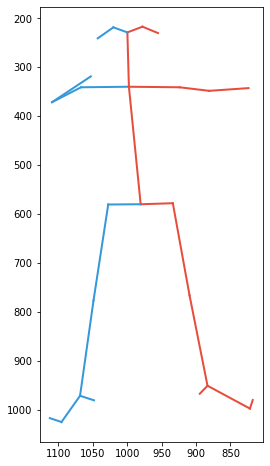

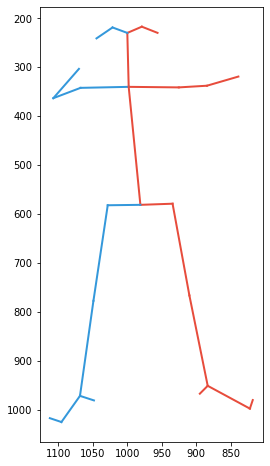

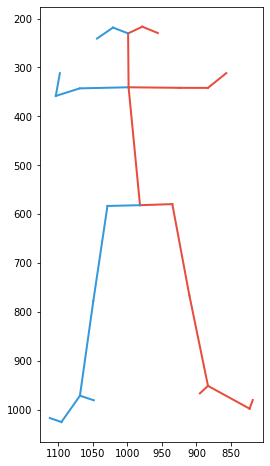

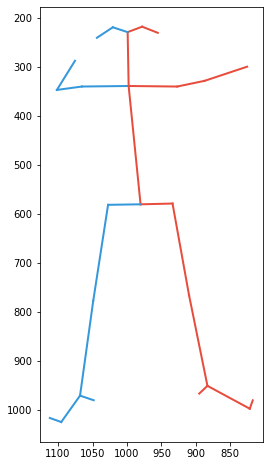

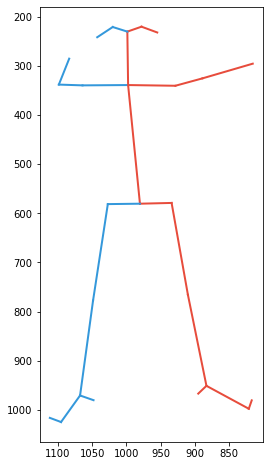

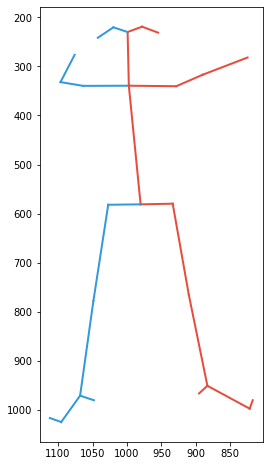

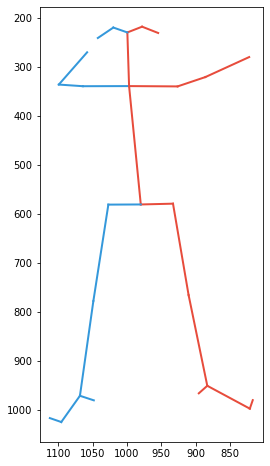

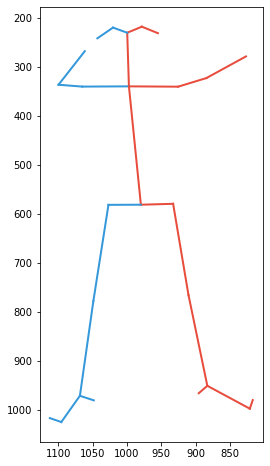

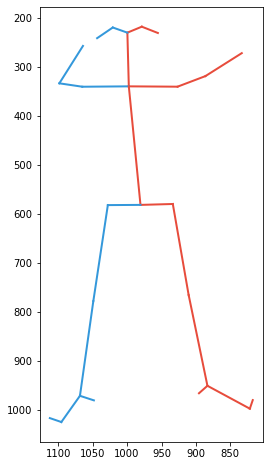

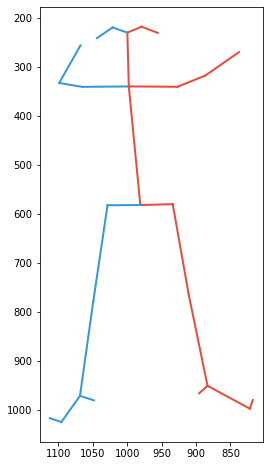

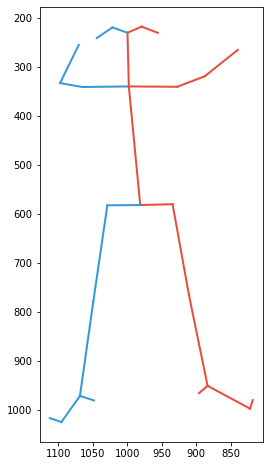

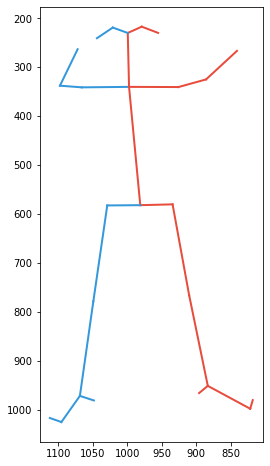

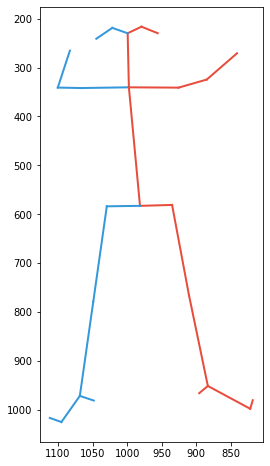

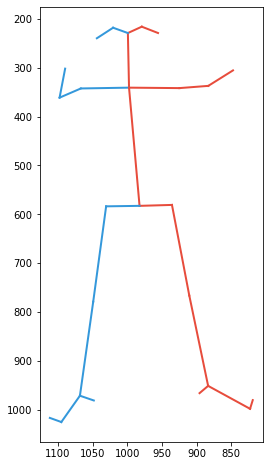

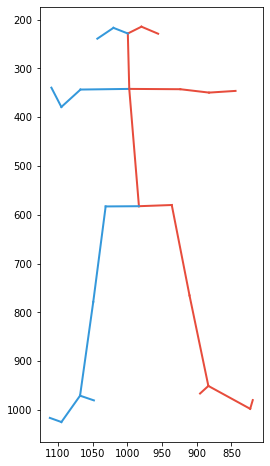

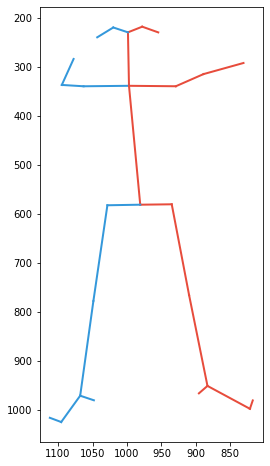

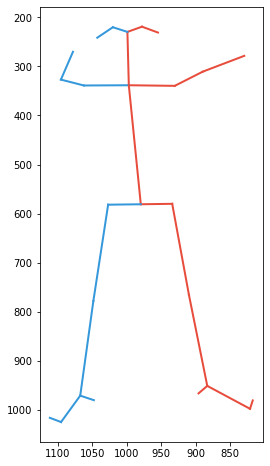

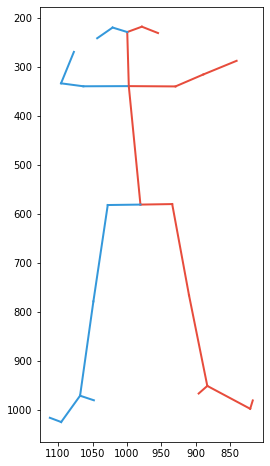

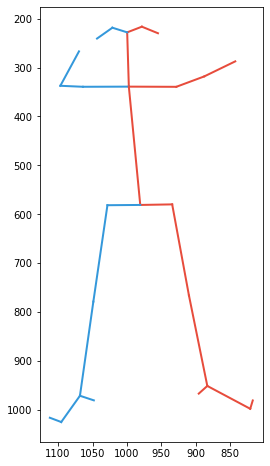

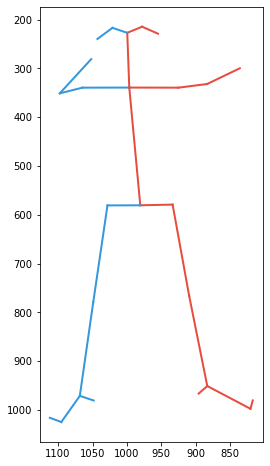

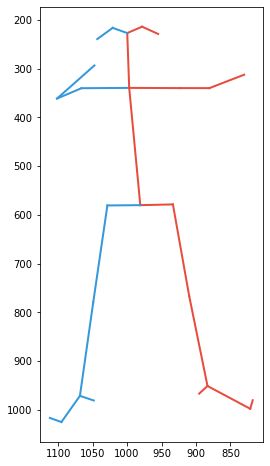

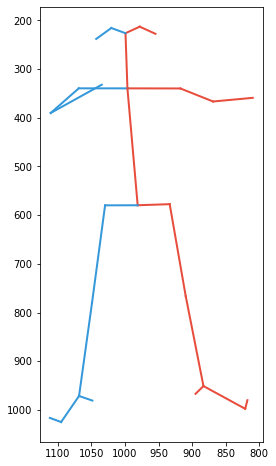

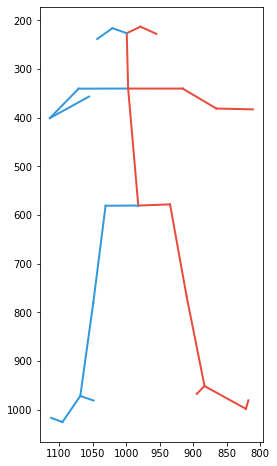

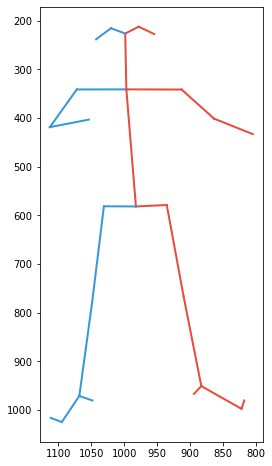

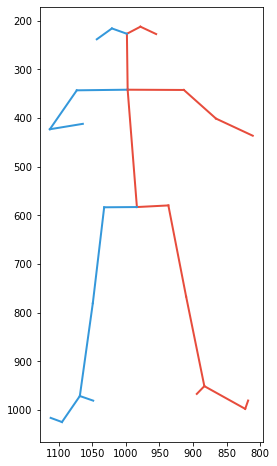

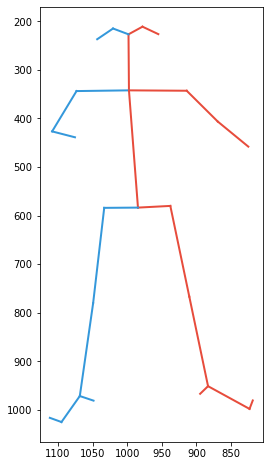

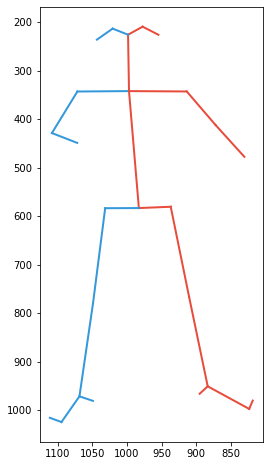

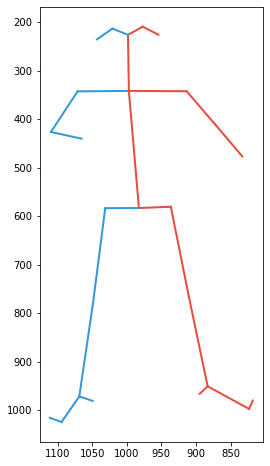

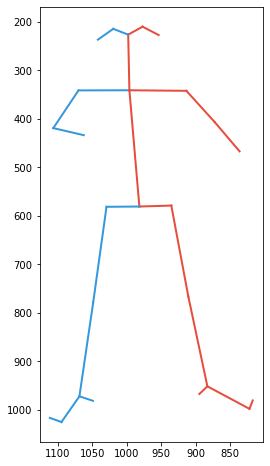

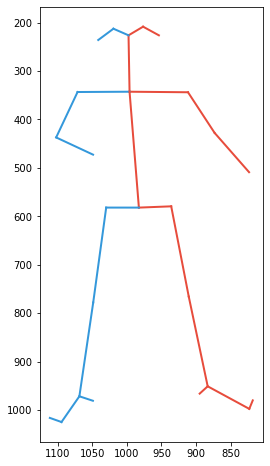

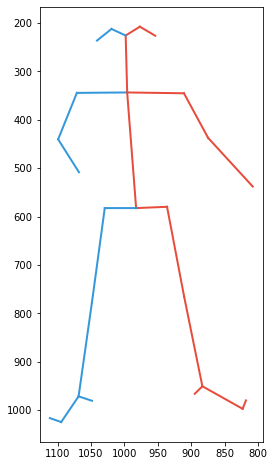

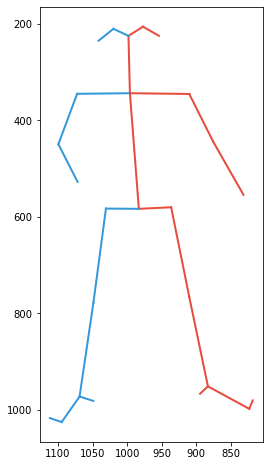

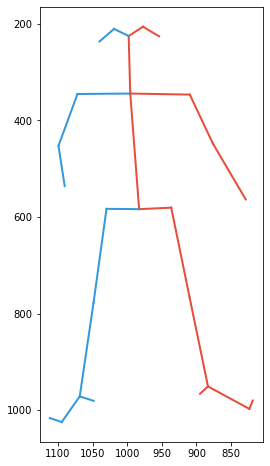

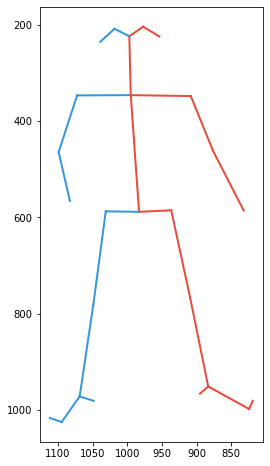

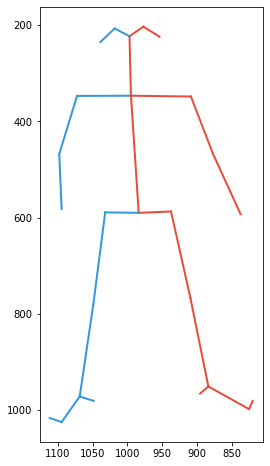

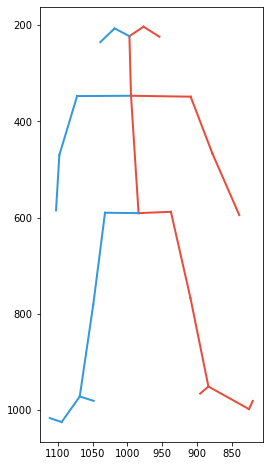

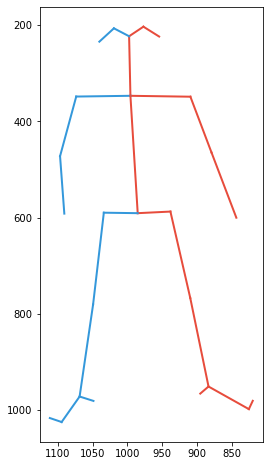

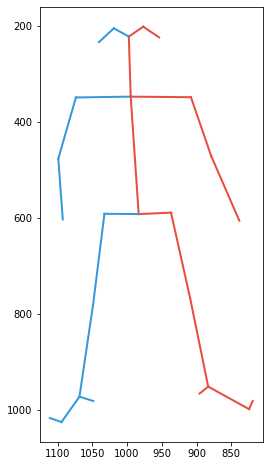

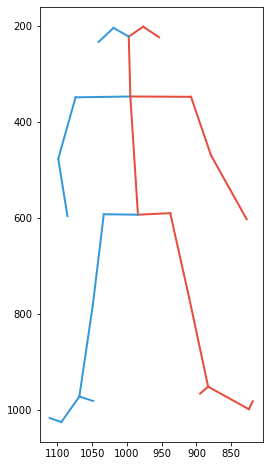

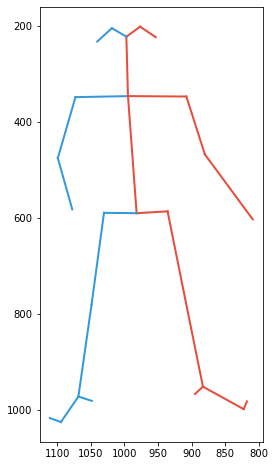

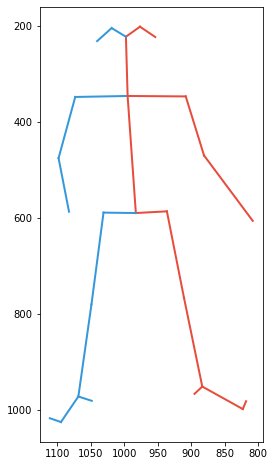

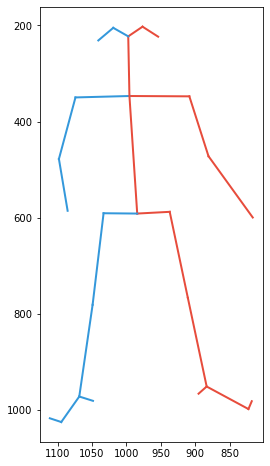

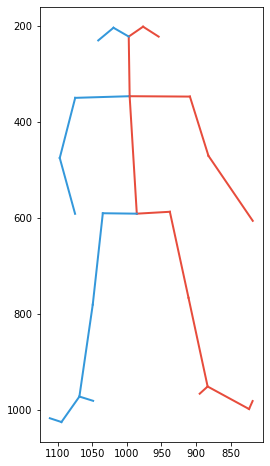

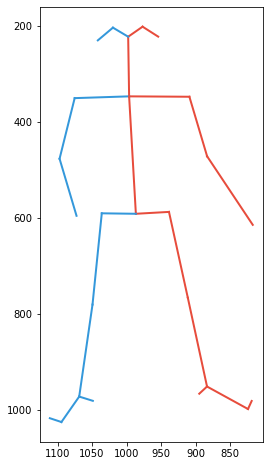

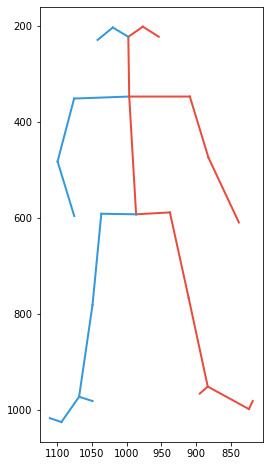

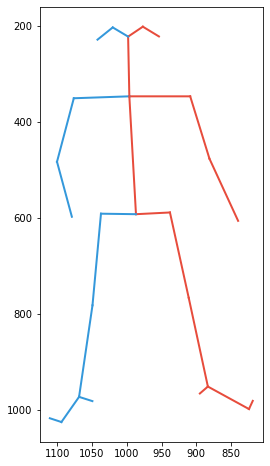

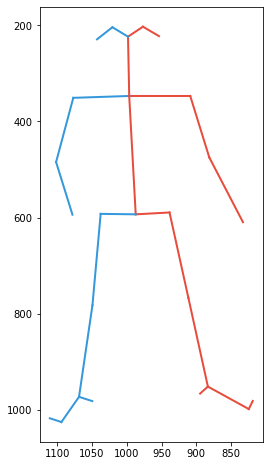

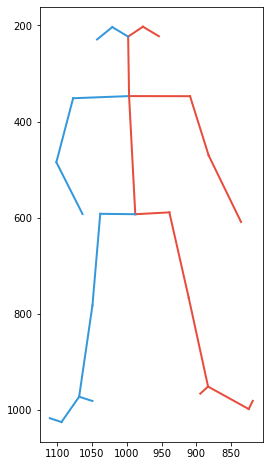

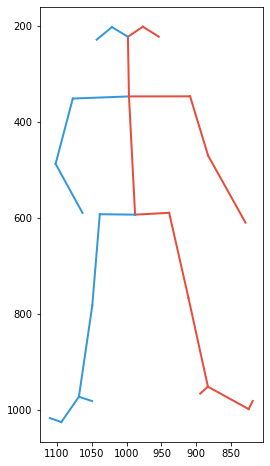

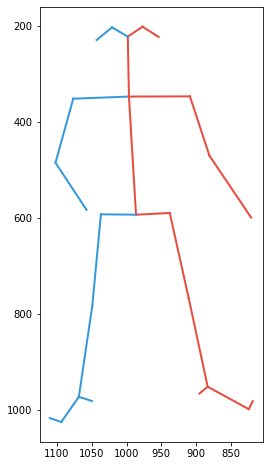

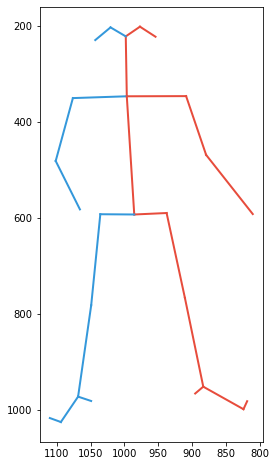

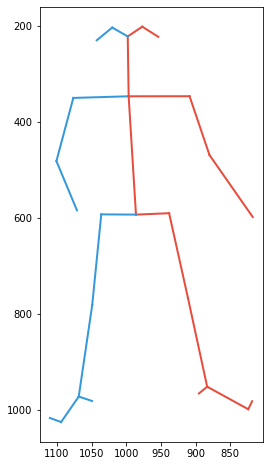

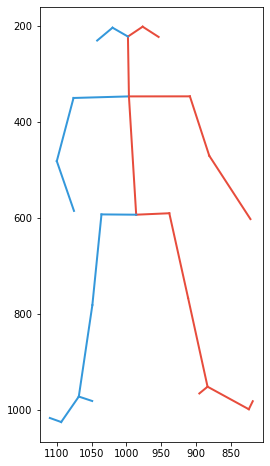

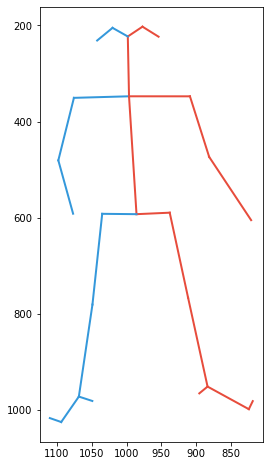

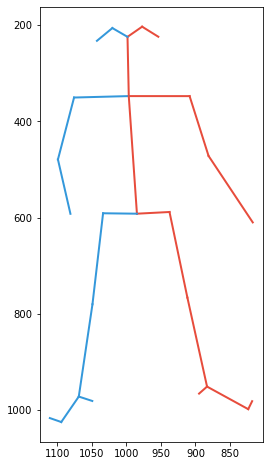

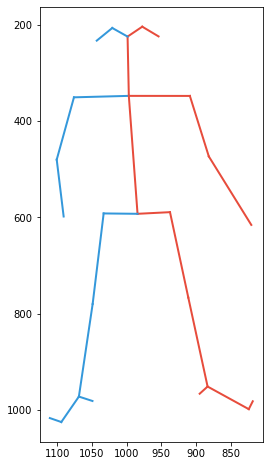

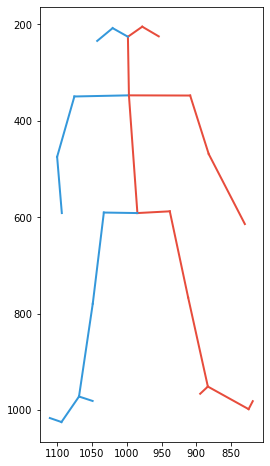

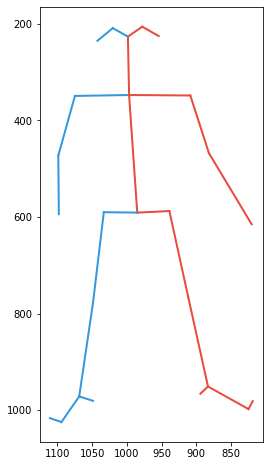

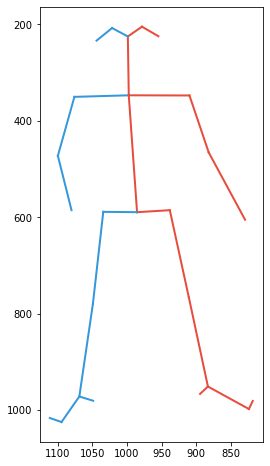

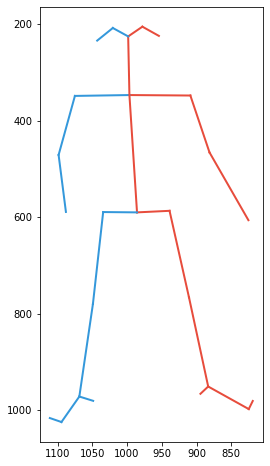

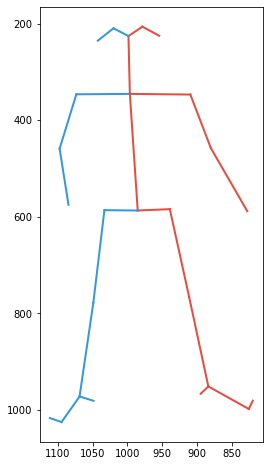

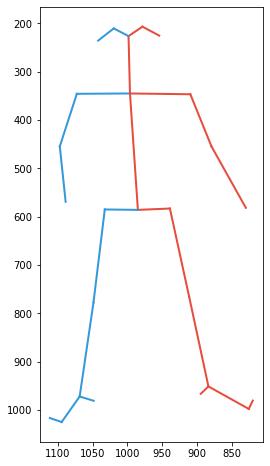

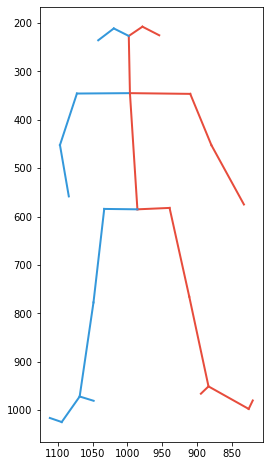

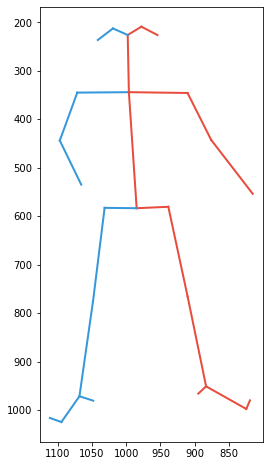

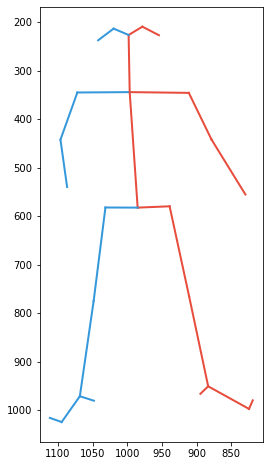

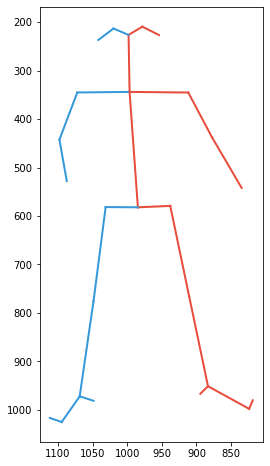

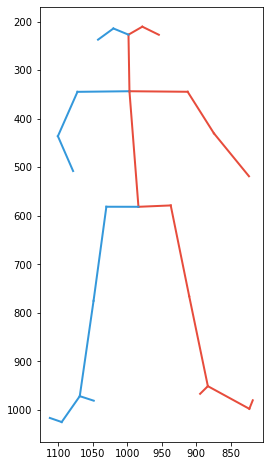

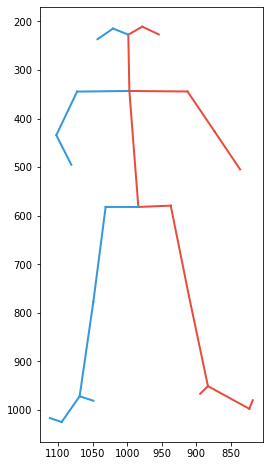

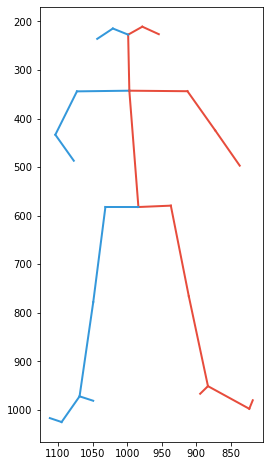

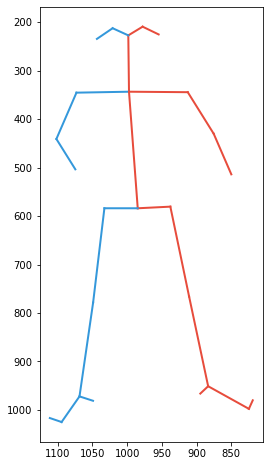

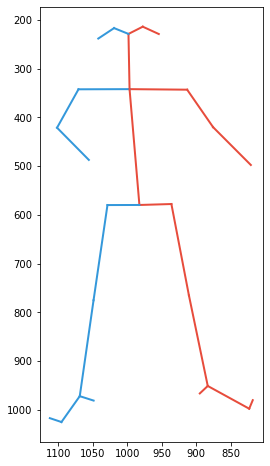

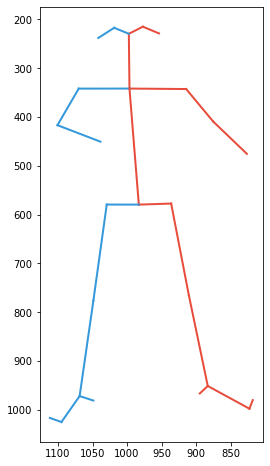

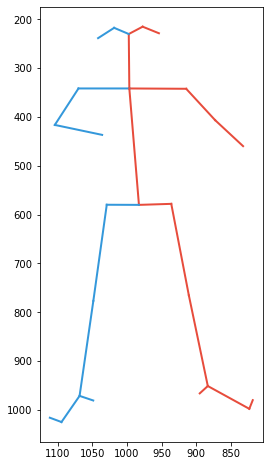

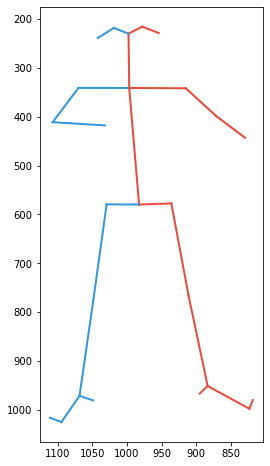

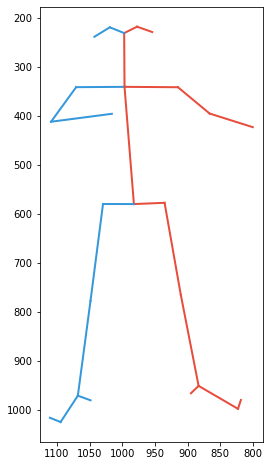

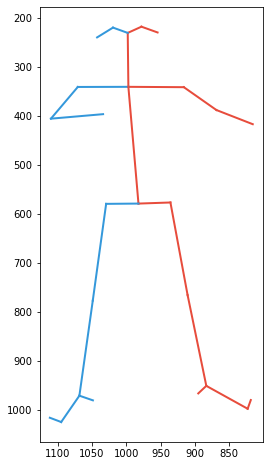

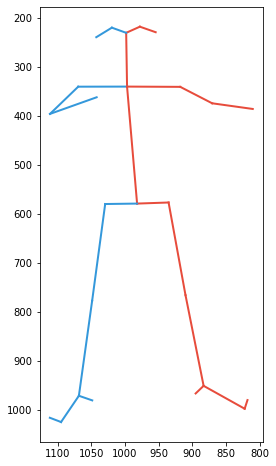

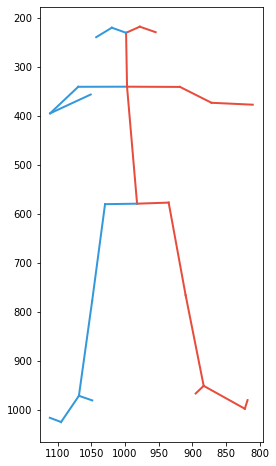

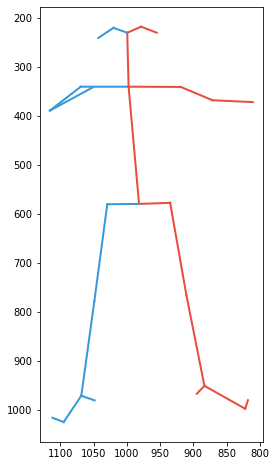

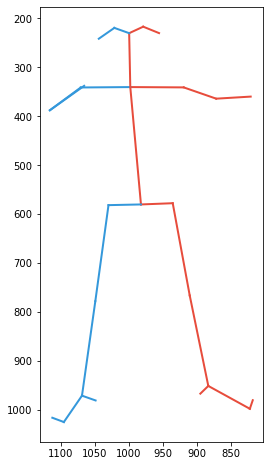

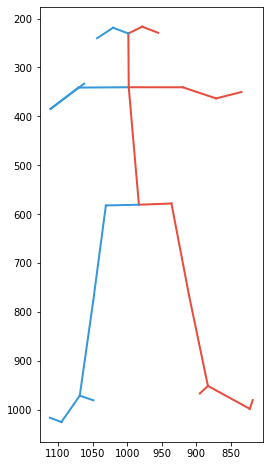

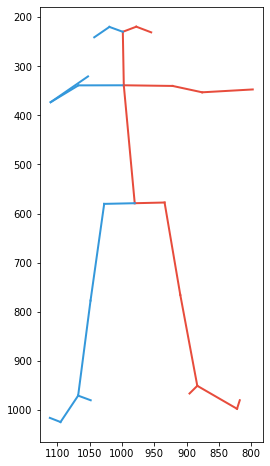

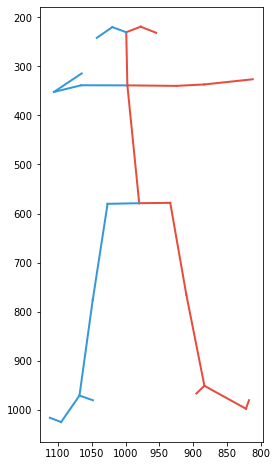

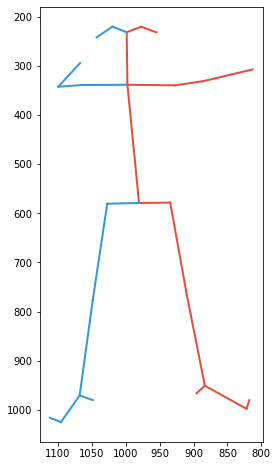

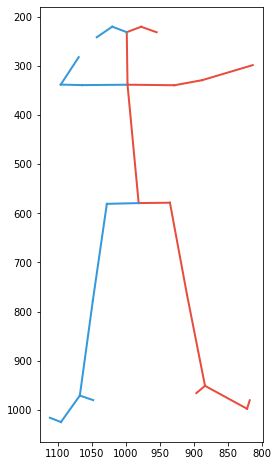

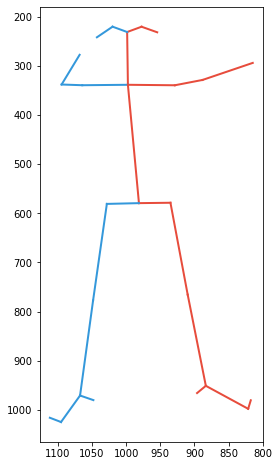

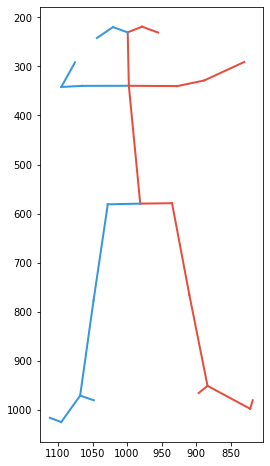

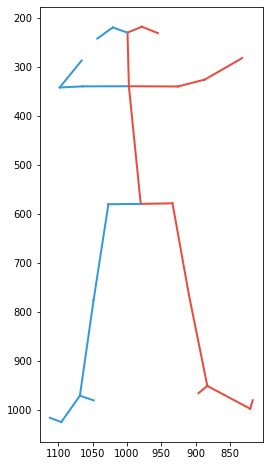

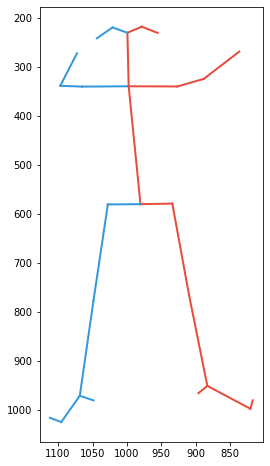

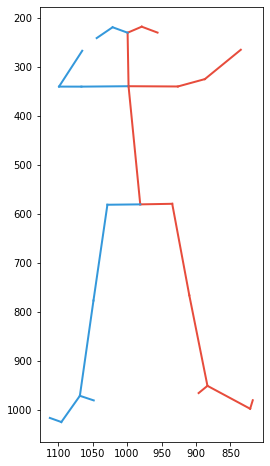

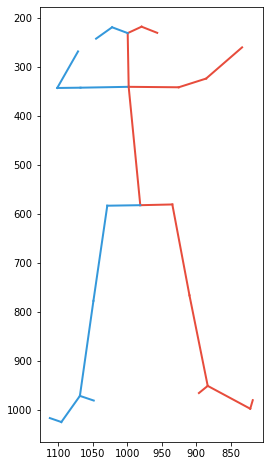

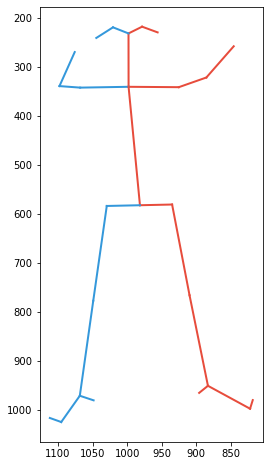

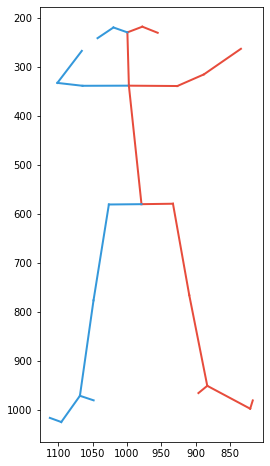

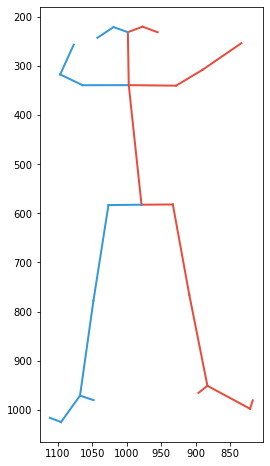

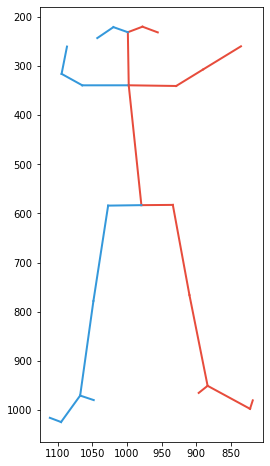

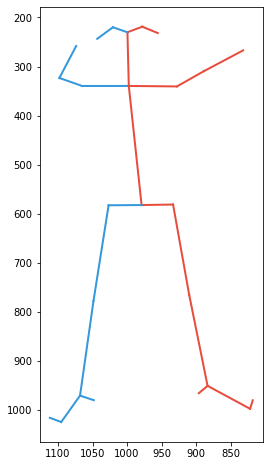

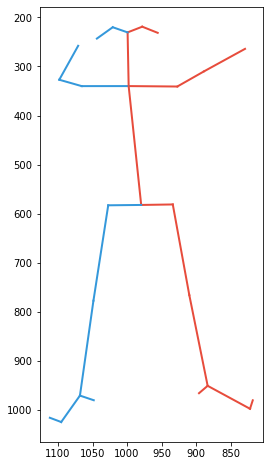

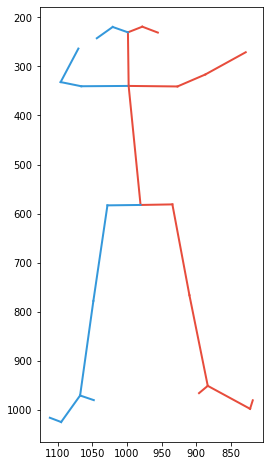

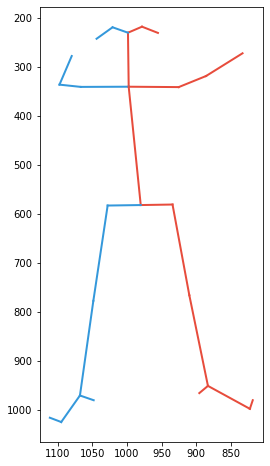

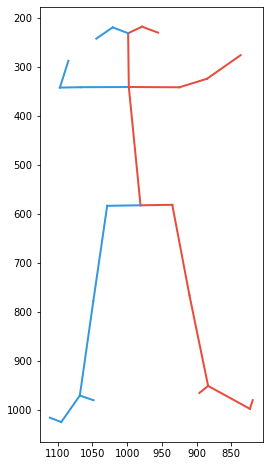

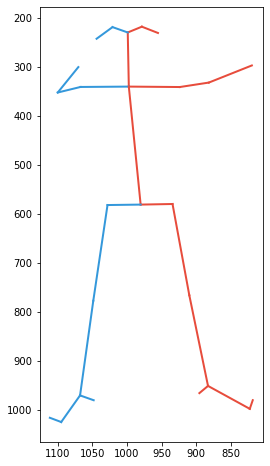

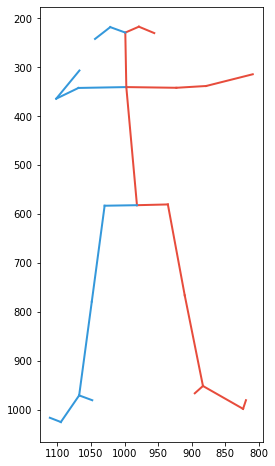

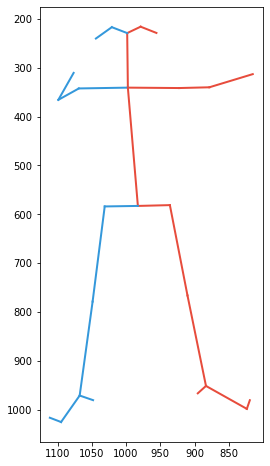

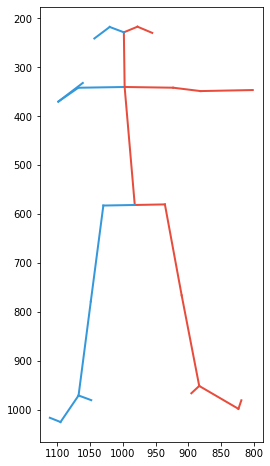

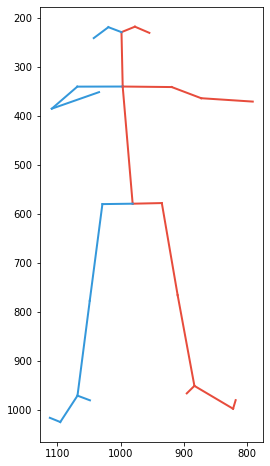

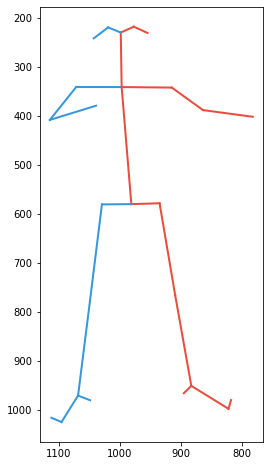

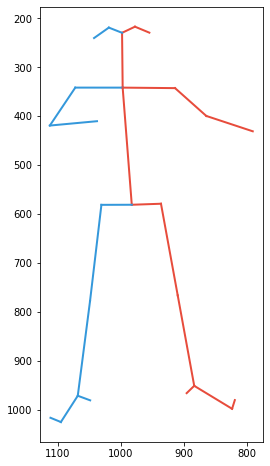

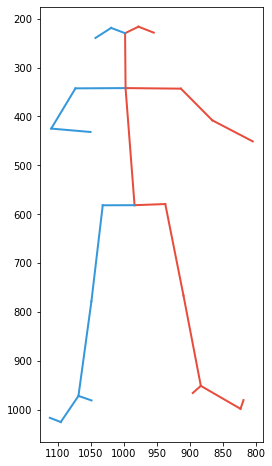

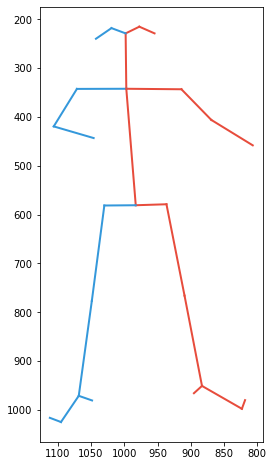

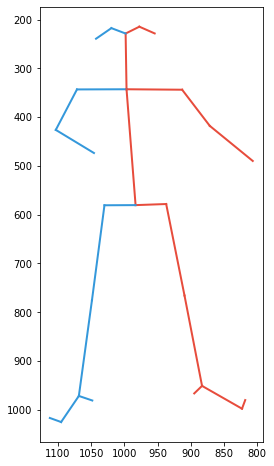

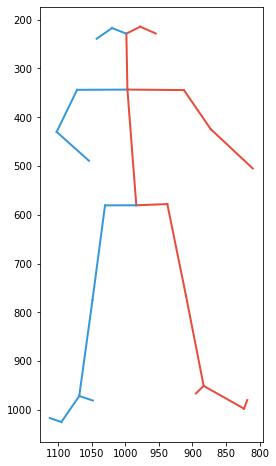

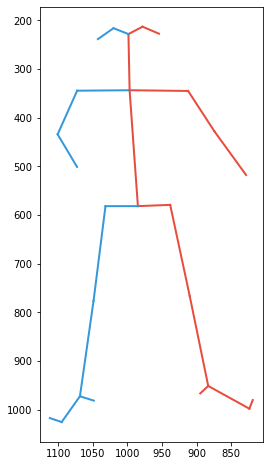

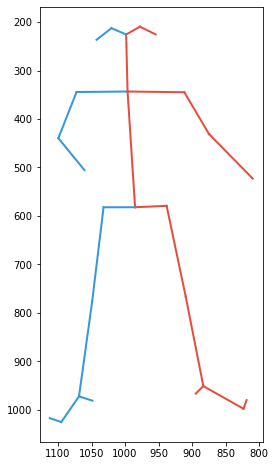

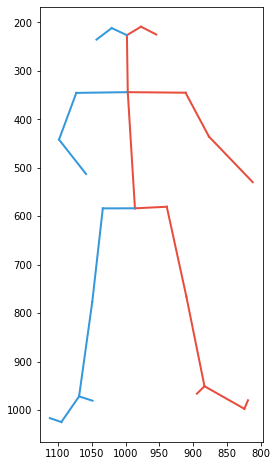

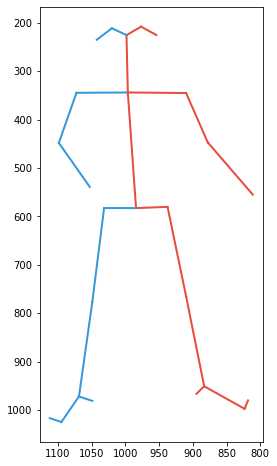

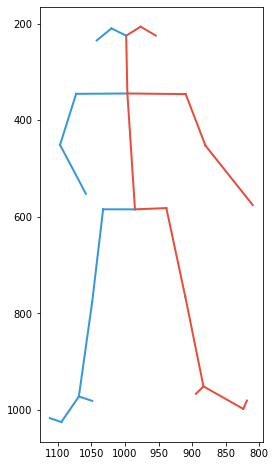

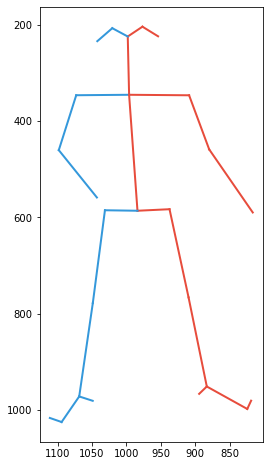

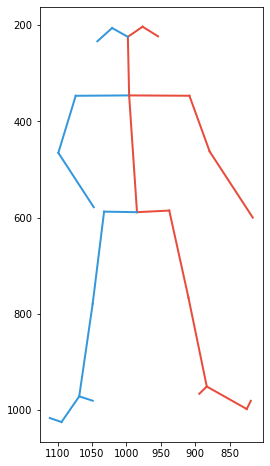

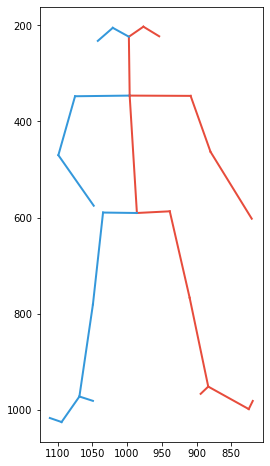

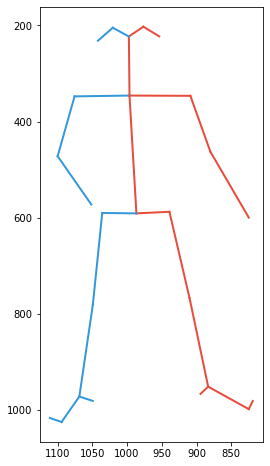

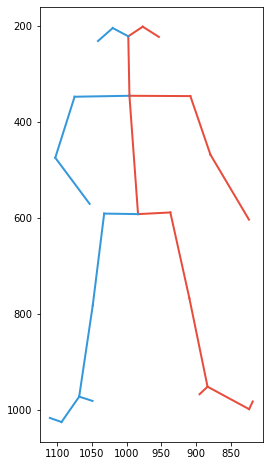

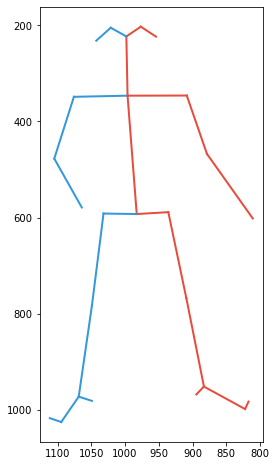

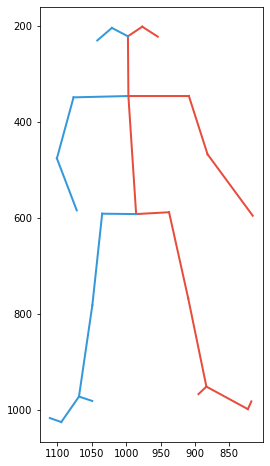

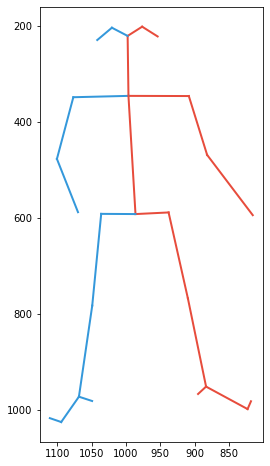

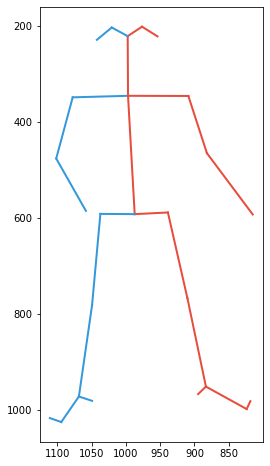

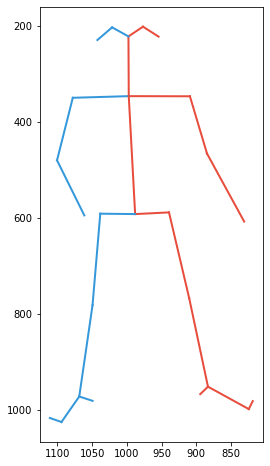

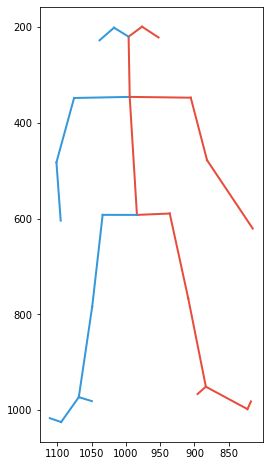

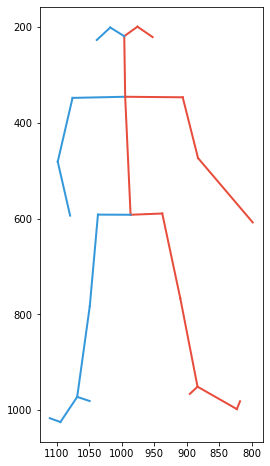

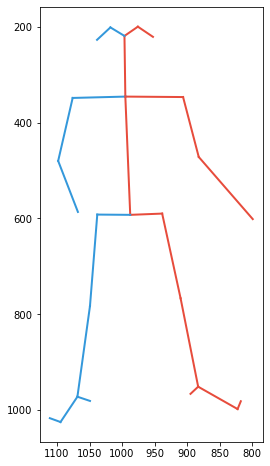

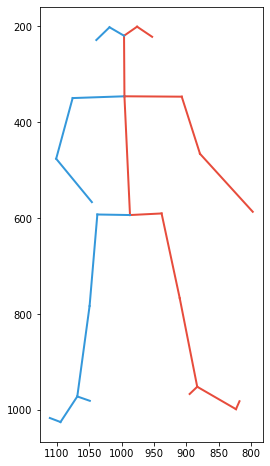

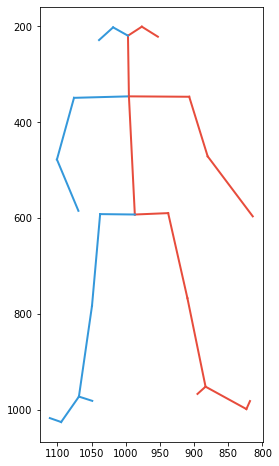

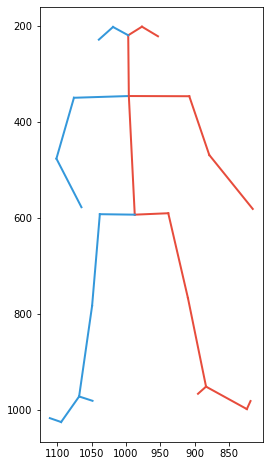

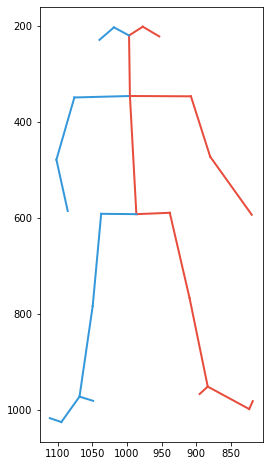

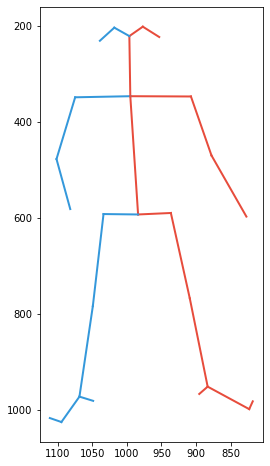

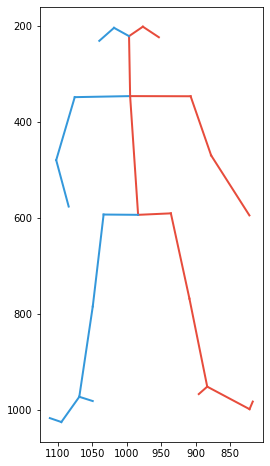

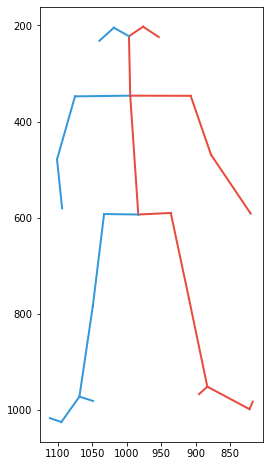

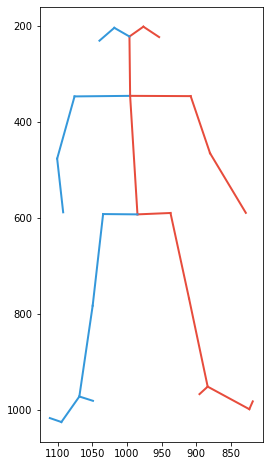

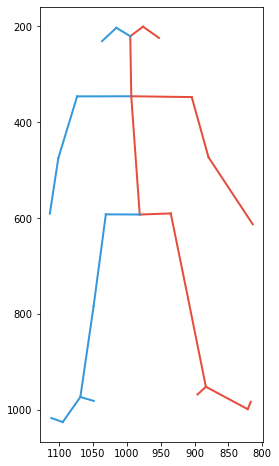

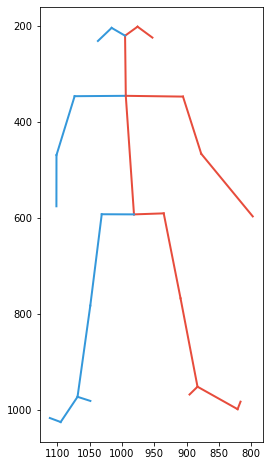

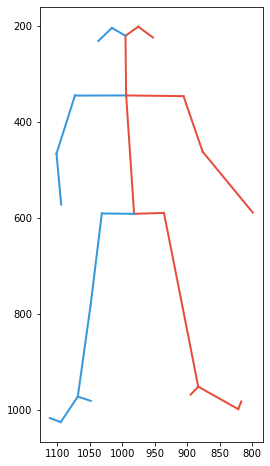

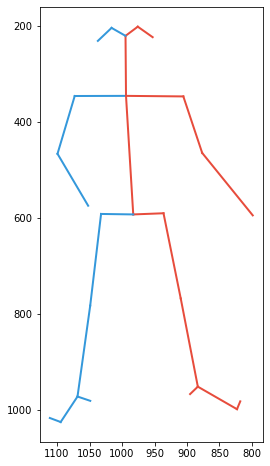

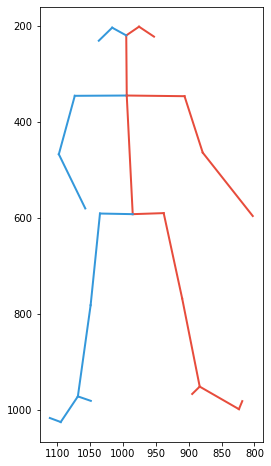

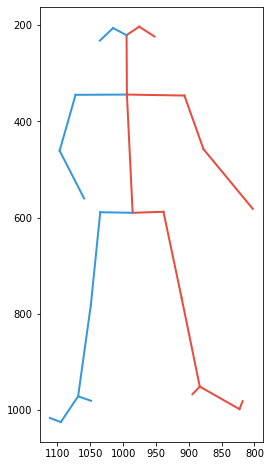

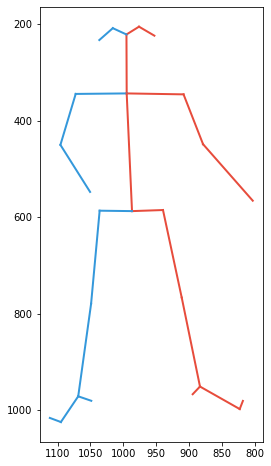

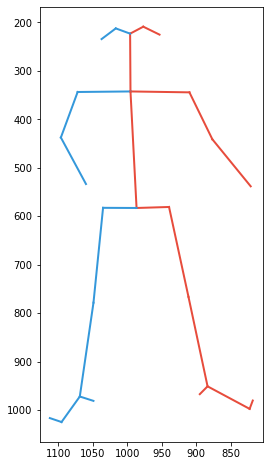

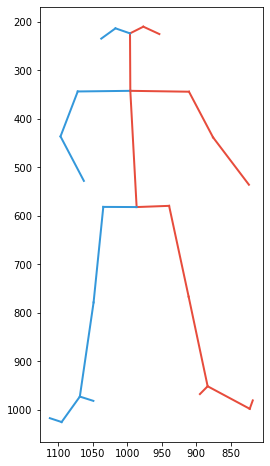

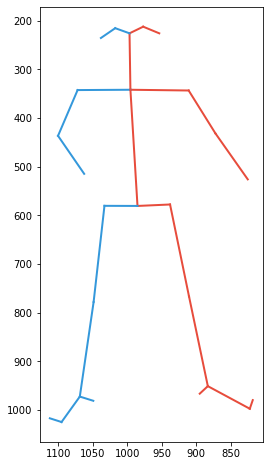

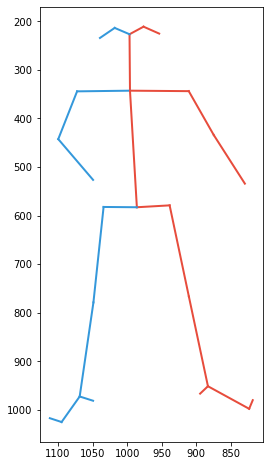

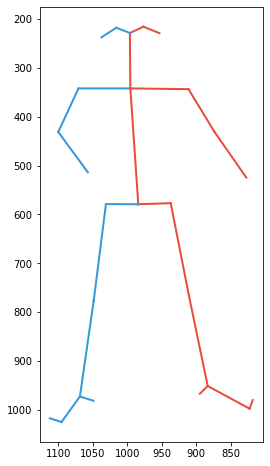

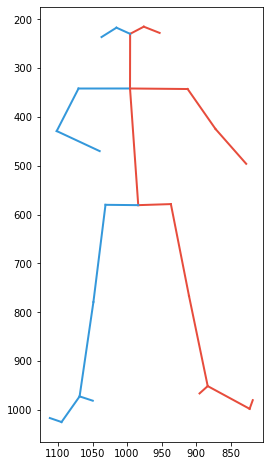

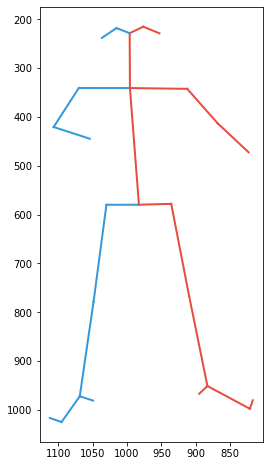

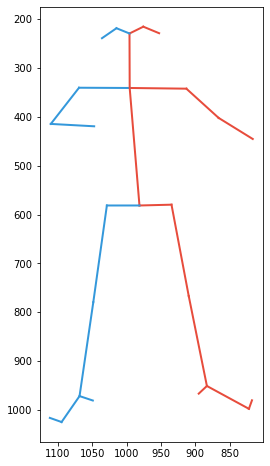

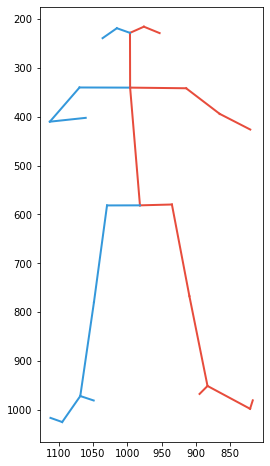

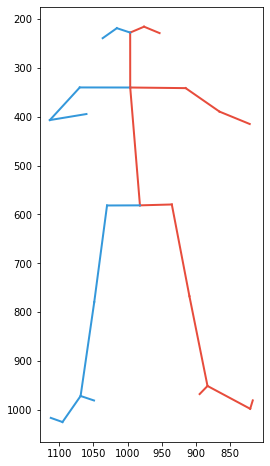

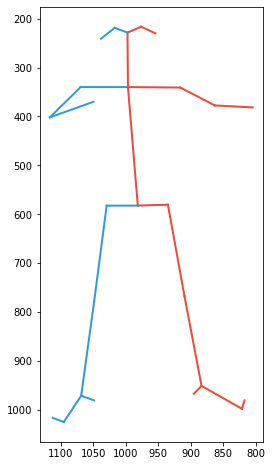

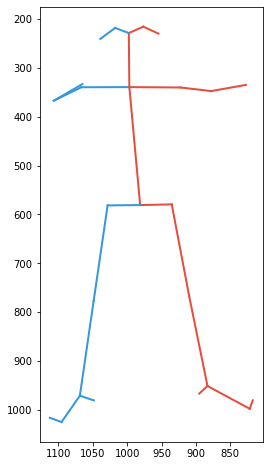

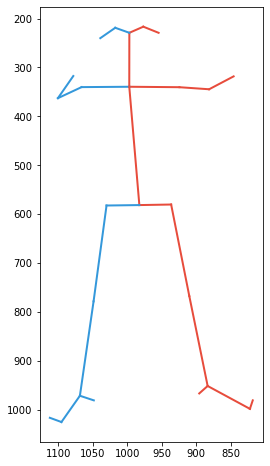

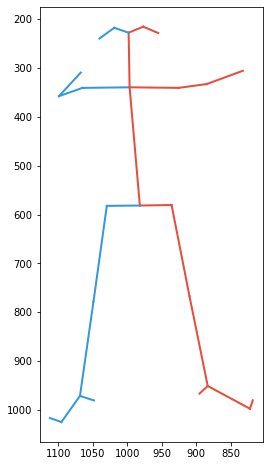

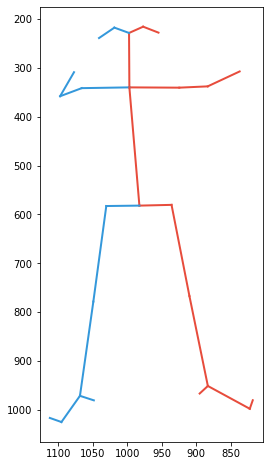

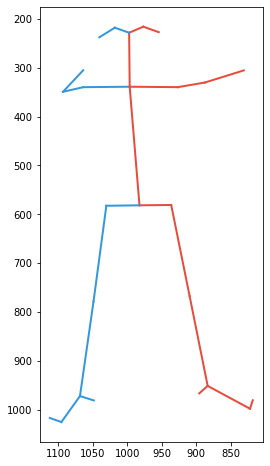

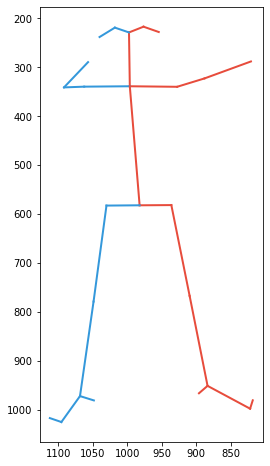

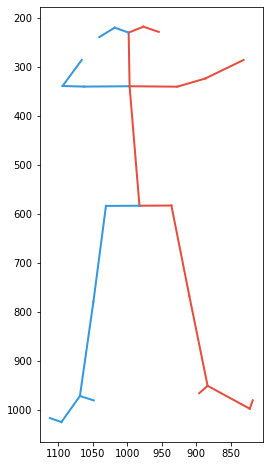

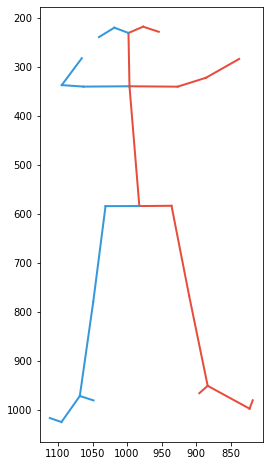

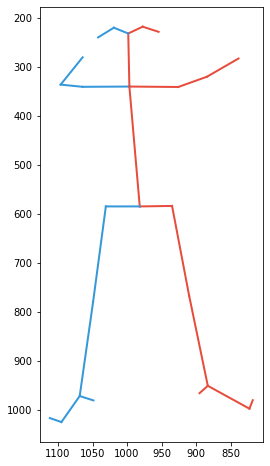

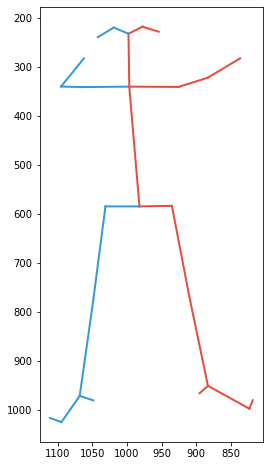

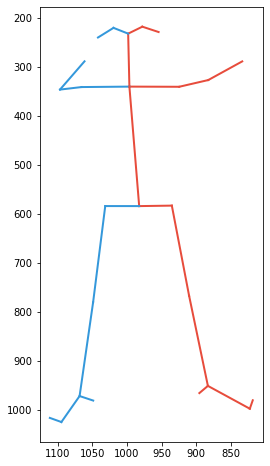

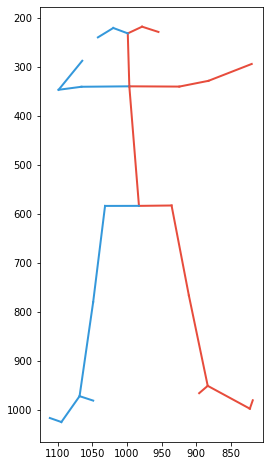

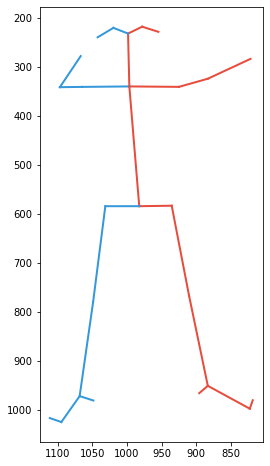

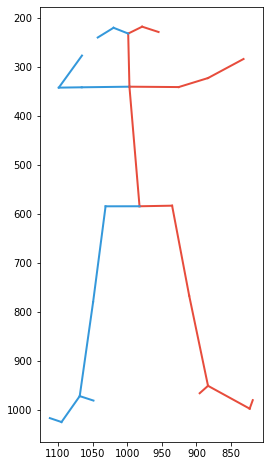

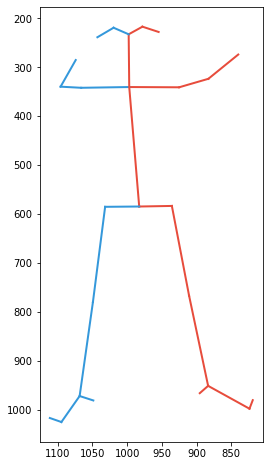

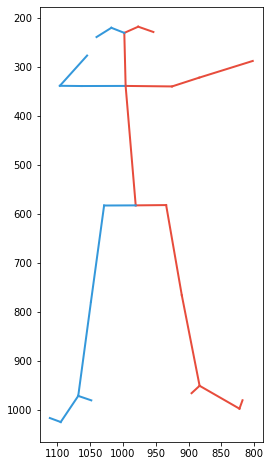

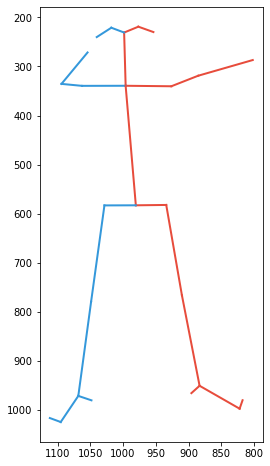

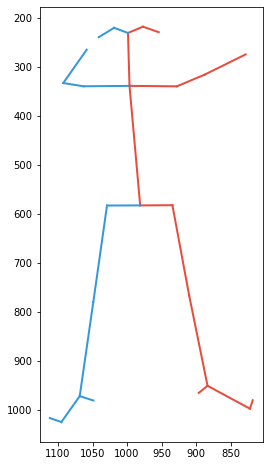

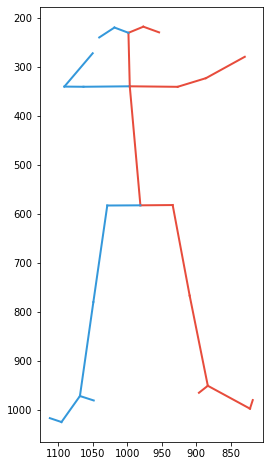

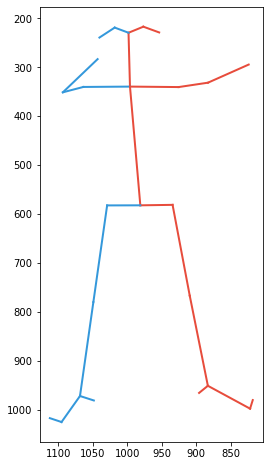

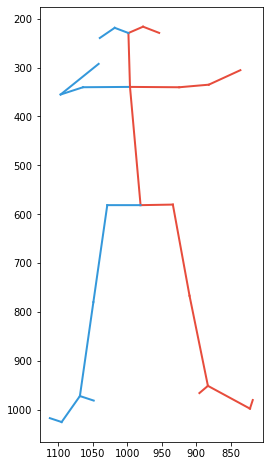

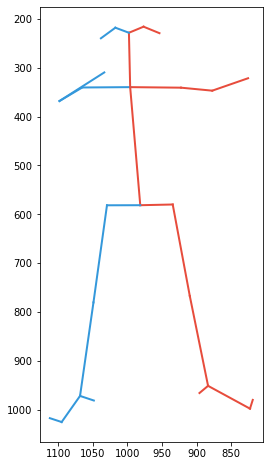

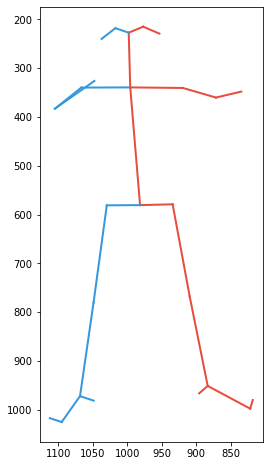

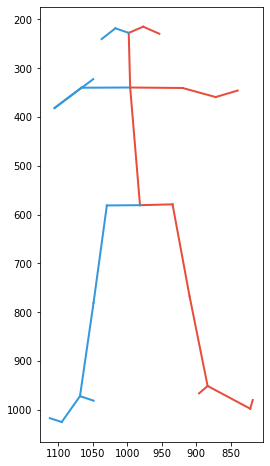

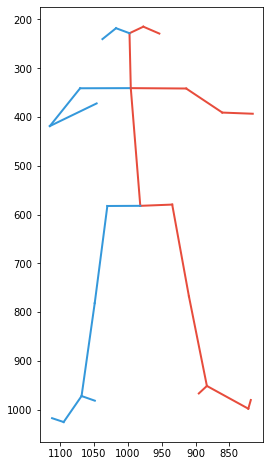

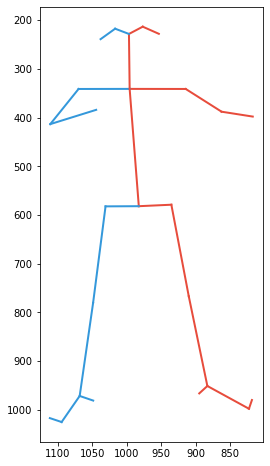

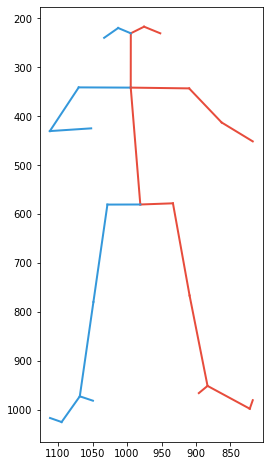

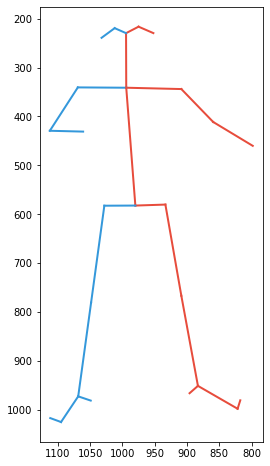

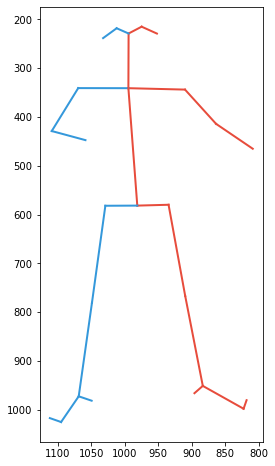

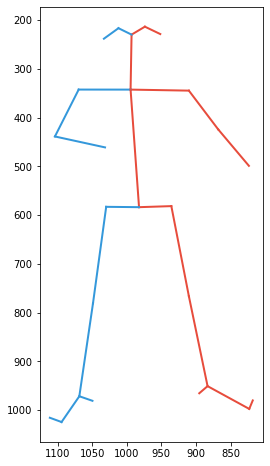

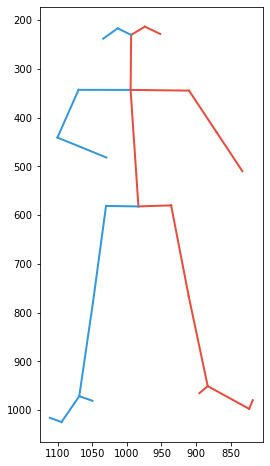

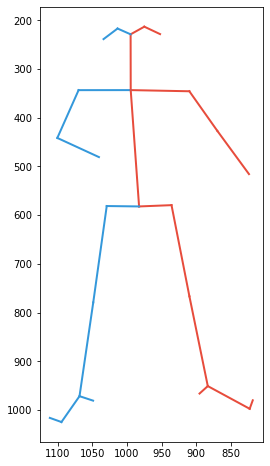

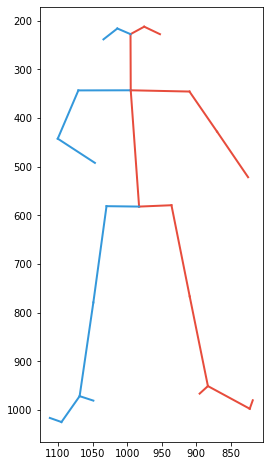

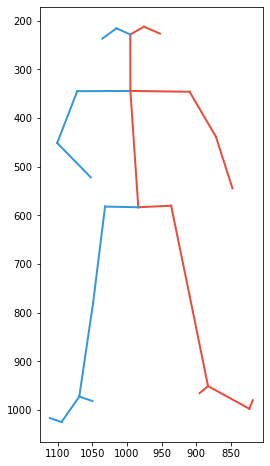

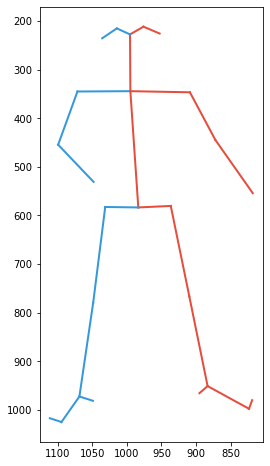

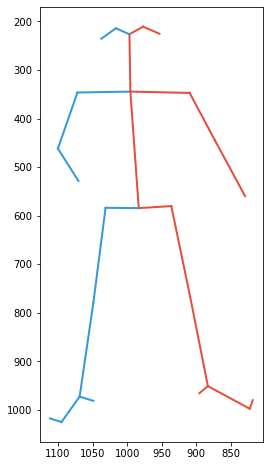

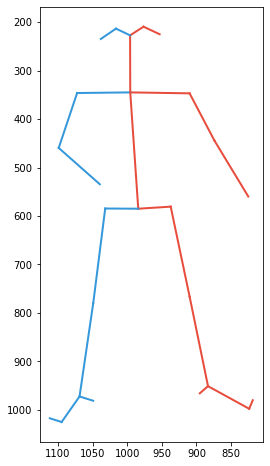

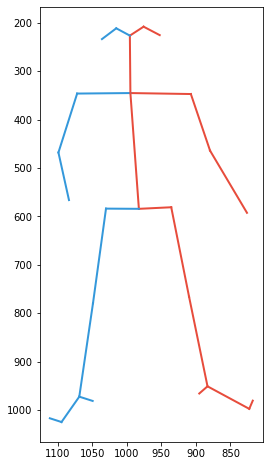

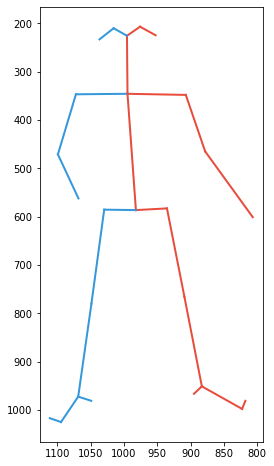

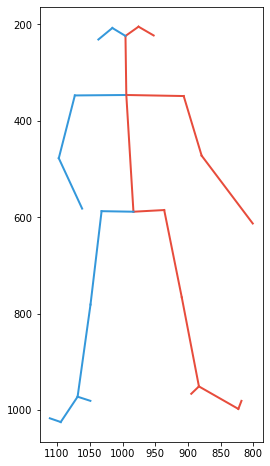

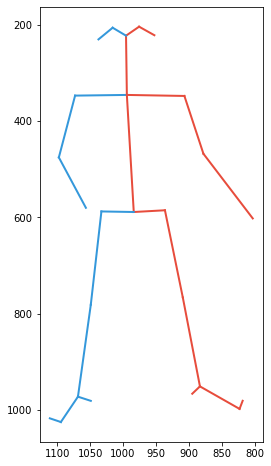

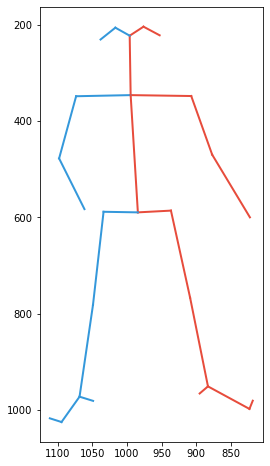

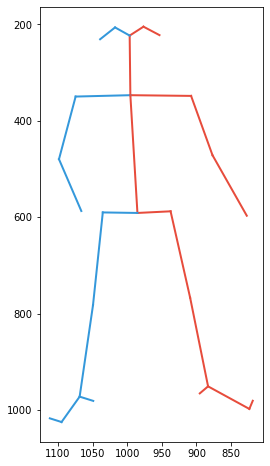

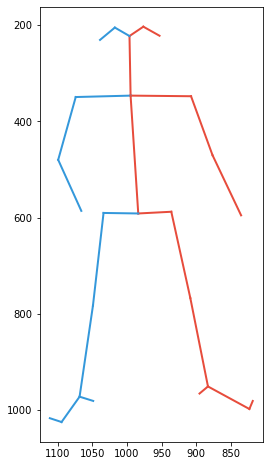

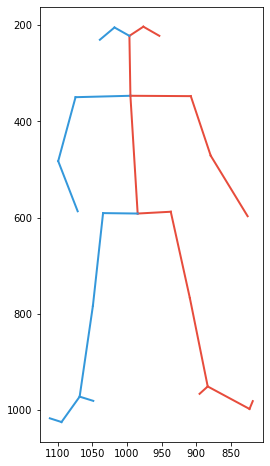

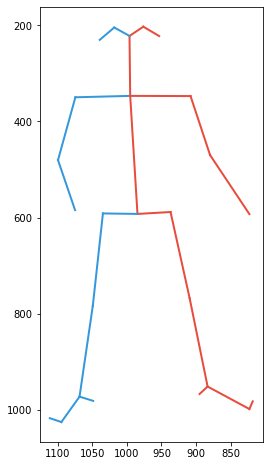

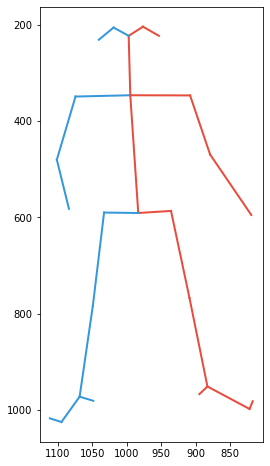

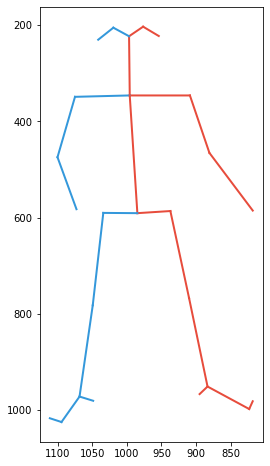

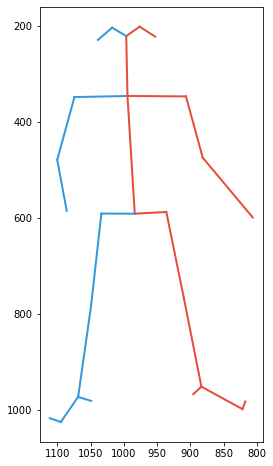

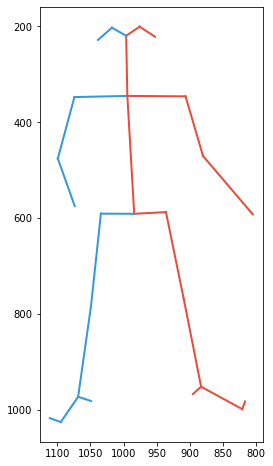

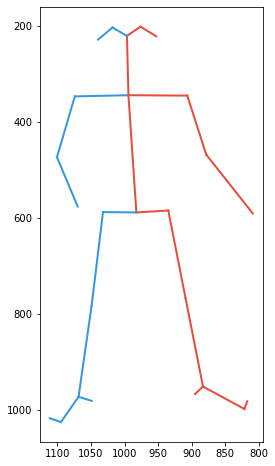

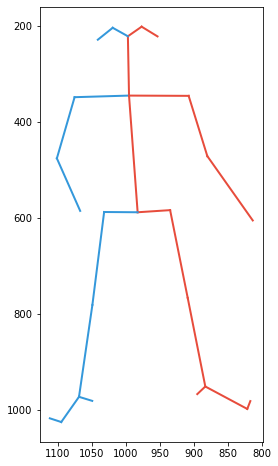

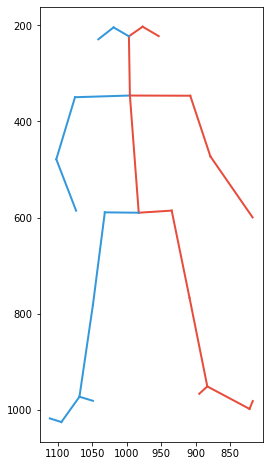

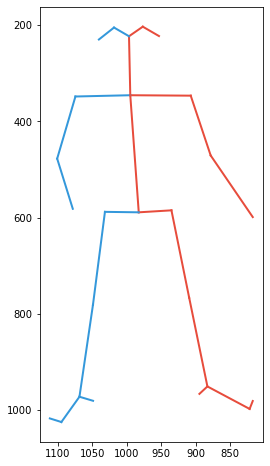

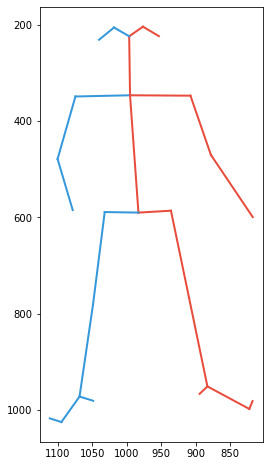

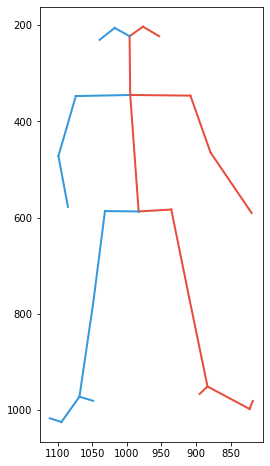

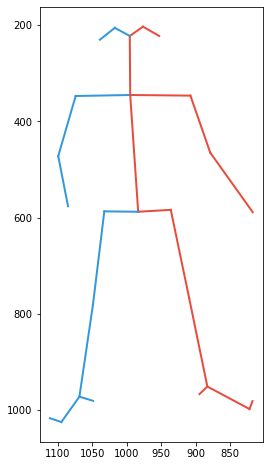

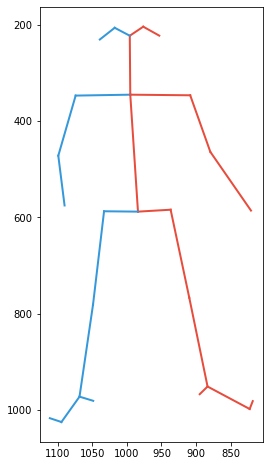

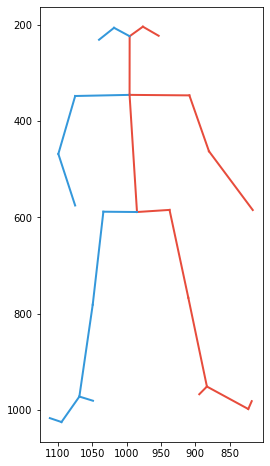

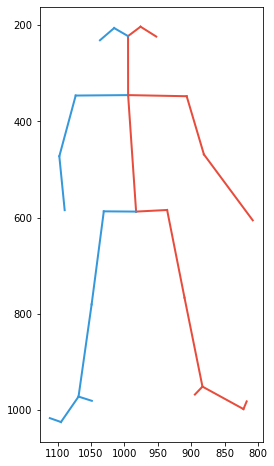

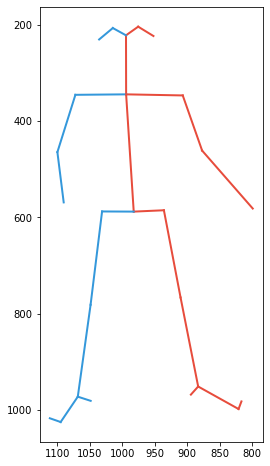

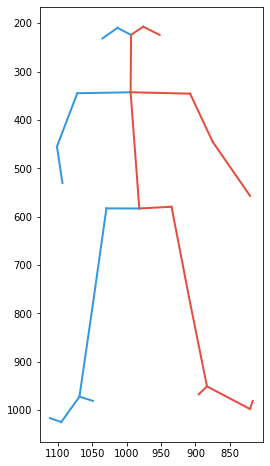

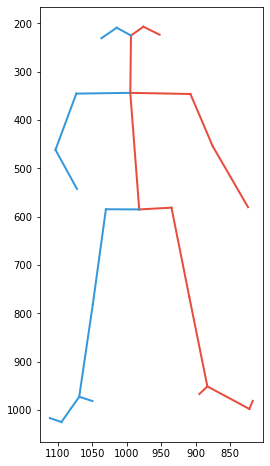

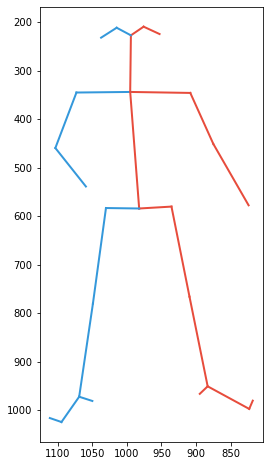

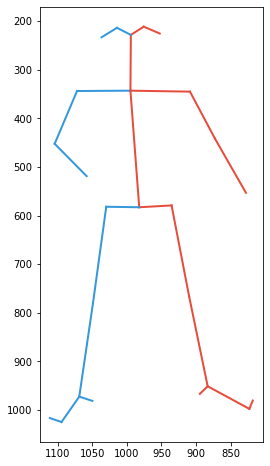

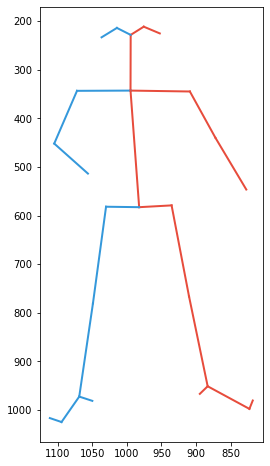

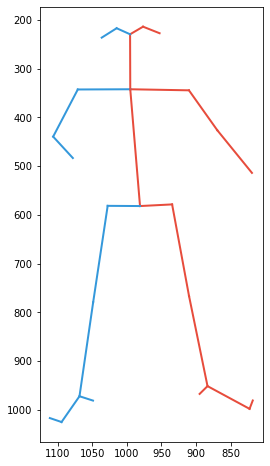

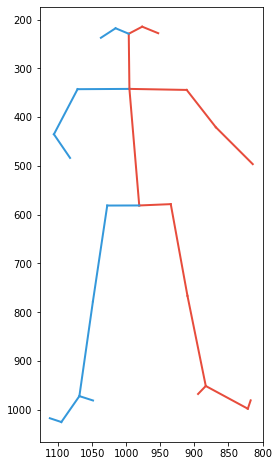

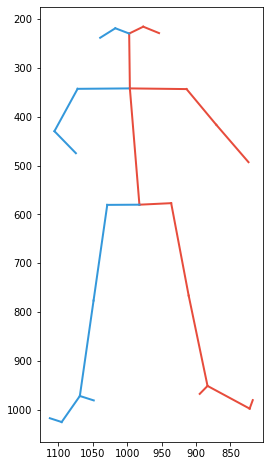

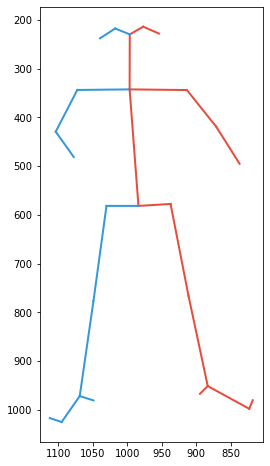

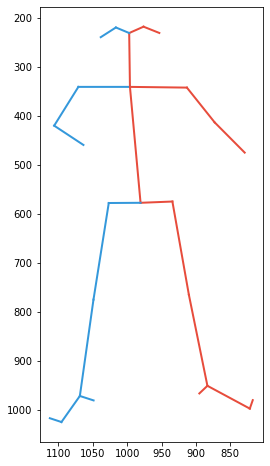

In [59]:
i = 0
for td in ps:
    fig = plt.figure(figsize=(4,8))
    ax = fig.add_subplot()
    ax.invert_xaxis()
    ax.invert_yaxis()
    draw2Dpose(td, ax)
    plt.show()
    fig.savefig('out_imgs/no_{}.png'.format(i))
    i += 1